# Constants

In [1]:
DATASET_PATH = '../data/breast_cancer.csv'

# Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn utilities
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Boosting algorithm
import lightgbm as lgb

# Add path to local project source code
import sys
sys.path.append('../src')

# Import custom Repeated Nested CV class
from RepeatedNestedCV import RepeatedNestedCV

# Analysis

## Algorithms & Params

In [16]:
# We use lambda **kwargs so that Optuna can pass hyperparameters into the constructor.
estimators = {
    "LR": lambda **kwargs: LogisticRegression(random_state=42, **kwargs),
    "GNB": GaussianNB,
    "LDA": LinearDiscriminantAnalysis,
    "SVC": lambda **kwargs: SVC(random_state=42, probability=True, **kwargs), # Without the "probability" fixed value, AUC will be none for SVM
    "RF": lambda **kwargs: RandomForestClassifier(random_state=42, **kwargs),
    "LGBM": lambda **kwargs: lgb.LGBMClassifier(random_state=42, verbosity=-1, **kwargs), # Suppress warnings here, lgb sends warnings outside python warnings module
}

param_spaces = {
    "LR": lambda trial: {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'solver': 'saga', # Fixed for Elastic Net Regularization
        'penalty': 'elasticnet', # Fixed for Elastic Net Regularization
        'max_iter': 1000
    },
    "GNB": lambda trial: {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    },
    "LDA": lambda trial: {
        'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    },
    "SVC": lambda trial: {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e0, log=True),
    },
    "RF": lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    },
    "LGBM": lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30)
    }
}

## Prepare Dataset

In [4]:
df = pd.read_csv(DATASET_PATH)
df.drop('id', axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].replace({'M': '1', 'B': '0'}).astype(int)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,0.05259,0.1586,...,19.07,30.88,123.40,1138.0,0.1464,0.1871,0.29140,0.16090,0.3029,0.08216
1,0,11.50,18.45,73.28,407.4,0.09345,0.05991,0.02638,0.02069,0.1834,...,12.97,22.46,83.12,508.9,0.1183,0.1049,0.08105,0.06544,0.2740,NaN
2,1,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.00,876.5,0.1131,0.1924,0.23220,0.11190,0.2809,0.06287
3,1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,0.08744,0.1943,...,22.66,30.93,145.30,1603.0,0.1390,0.3463,0.39120,0.17080,0.3007,0.08314
4,0,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,...,13.74,19.93,88.81,585.4,0.1483,NaN,0.22410,0.10560,0.3380,0.09584


## nCV

In [5]:
# Extract X and y from dataframe
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values

In [6]:
rncv = RepeatedNestedCV(
    X=X,
    y=y,
    estimators=estimators,
    param_spaces=param_spaces,
)

rncv.run()

[I 2025-04-27 16:47:29,781] A new study created in memory with name: no-name-9ac64d65-6fb2-44a6-9b2c-2cb53fe2f094
[I 2025-04-27 16:47:29,810] Trial 0 finished with value: 0.8702859020958894 and parameters: {'C': 0.017670169402947963, 'l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.8702859020958894.
[I 2025-04-27 16:47:29,895] Trial 1 finished with value: 0.9393040981882704 and parameters: {'C': 2.4658329458549115, 'l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-04-27 16:47:29,910] Trial 2 finished with value: 0.41353986515276836 and parameters: {'C': 0.0008632008168602552, 'l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-04-27 16:47:29,920] Trial 3 finished with value: 0.0 and parameters: {'C': 0.00022310108018679258, 'l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.9393040981882704.
[I 2025-04-27 16:47:29,948] Trial 4 finished with value: 0.9462551697346605 and parameters: {'


>>> Repetition 1/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 16:47:30,045] Trial 6 finished with value: 0.9372251342781337 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-04-27 16:47:30,058] Trial 7 finished with value: 0.6274179037336932 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-04-27 16:47:30,070] Trial 8 finished with value: 0.8609214171398861 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-04-27 16:47:30,084] Trial 9 finished with value: 0.923611111111111 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.9462551697346605.
[I 2025-04-27 16:47:30,120] Trial 10 finished with value: 0.9462585034013605 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 10 with value: 0.94625850340136

Tuning: GNB


[I 2025-04-27 16:47:31,939] Trial 17 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 1.1272048050586266e-09}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-04-27 16:47:31,953] Trial 18 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-04-27 16:47:31,965] Trial 19 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-04-27 16:47:31,977] Trial 20 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-04-27 16:47:31,988] Trial 21 finished with value: 0.8844444444444445 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8844444444444445.
[I 2025-04-27 16:47:32,002] Trial 22 finished with value: 0.8844444444444445 and pa

Tuning: LDA


[I 2025-04-27 16:47:32,547] Trial 17 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,557] Trial 18 finished with value: 0.9338350881041165 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,568] Trial 19 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,579] Trial 20 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,590] Trial 21 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,601] Trial 22 finished with value: 0.9338350881041165 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9338350881041165.
[I 2025-04-27 16:47:32,611] Trial 2

Tuning: SVC


[I 2025-04-27 16:47:33,124] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-04-27 16:47:33,153] Trial 8 finished with value: 0.8219753375093838 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-04-27 16:47:33,180] Trial 9 finished with value: 0.7061208833360731 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-04-27 16:47:33,201] Trial 10 finished with value: 0.9381954163909052 and parameters: {'C': 77.62120319752464, 'gamma': 0.00010567900894501651}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-04-27 16:47:33,226] Trial 11 finished with value: 0.9403646130414508 and parameters: {'C': 2.544767558218772, 'gamma': 0.07631550861559508}. Best is trial 6 with value: 0.9414249910490513.
[I 2025-04-27 16:

Tuning: RF


[I 2025-04-27 16:47:34,304] Trial 0 finished with value: 0.8947695919472994 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8947695919472994.
[I 2025-04-27 16:47:34,442] Trial 1 finished with value: 0.8901510248112189 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8947695919472994.
[I 2025-04-27 16:47:34,701] Trial 2 finished with value: 0.9019895579301519 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9019895579301519.
[I 2025-04-27 16:47:35,026] Trial 3 finished with value: 0.9103047962021038 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9103047962021038.
[I 2025-04-27 16:47:35,213] Trial 4 finished with value: 0.9203247115618249 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 16:47:46,338] Trial 0 finished with value: 0.9205228758169935 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9205228758169935.
[I 2025-04-27 16:47:46,566] Trial 1 finished with value: 0.8990727644192992 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9205228758169935.
[I 2025-04-27 16:47:46,775] Trial 2 finished with value: 0.9236878589819767 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9236878589819767.
[I 2025-04-27 16:47:47,185] Trial 3 finished with value: 0.9240129449838187 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 16:48:07,207] Trial 6 finished with value: 0.9490982539462145 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.963330689928628.
[I 2025-04-27 16:48:07,218] Trial 7 finished with value: 0.6422222222222222 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.963330689928628.
[I 2025-04-27 16:48:07,231] Trial 8 finished with value: 0.8600522685765677 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.963330689928628.
[I 2025-04-27 16:48:07,245] Trial 9 finished with value: 0.941968196213193 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.963330689928628.
[I 2025-04-27 16:48:07,280] Trial 10 finished with value: 0.970204081632653 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 10 with value: 0.970204081632653.
[I

Tuning: GNB


[I 2025-04-27 16:48:09,228] Trial 17 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 1.1272048050586266e-09}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-04-27 16:48:09,240] Trial 18 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-04-27 16:48:09,252] Trial 19 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-04-27 16:48:09,264] Trial 20 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-04-27 16:48:09,275] Trial 21 finished with value: 0.8511275491108968 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8511275491108968.
[I 2025-04-27 16:48:09,288] Trial 22 finished with value: 0.8511275491108968 and pa

Tuning: LDA


[I 2025-04-27 16:48:09,836] Trial 19 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,847] Trial 20 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,857] Trial 21 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,867] Trial 22 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,877] Trial 23 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,887] Trial 24 finished with value: 0.9405310511301295 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405310511301295.
[I 2025-04-27 16:48:09,897] Trial 

Tuning: SVC


[I 2025-04-27 16:48:10,364] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-04-27 16:48:10,393] Trial 8 finished with value: 0.8045404208194906 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-04-27 16:48:10,421] Trial 9 finished with value: 0.703343070431678 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-04-27 16:48:10,441] Trial 10 finished with value: 0.9488845343071762 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-04-27 16:48:10,471] Trial 11 finished with value: 0.8538361139484735 and parameters: {'C': 3.7808751628406823, 'gamma': 0.00011154569588957049}. Best is trial 1 with value: 0.9640504191003636.
[I 2025-04-27 16:4

Tuning: RF


[I 2025-04-27 16:48:11,666] Trial 1 finished with value: 0.9248072562358276 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-04-27 16:48:11,923] Trial 2 finished with value: 0.9210243822614957 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-04-27 16:48:12,241] Trial 3 finished with value: 0.9243435692033822 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9345935545935545.
[I 2025-04-27 16:48:12,425] Trial 4 finished with value: 0.9383571746455591 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9383571746455591.
[I 2025-04-27 16:48:12,683] Trial 5 finished with value: 0.9240201818910797 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 16:48:26,446] Trial 0 finished with value: 0.9242579642579644 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-04-27 16:48:26,653] Trial 1 finished with value: 0.9114842430206312 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-04-27 16:48:26,852] Trial 2 finished with value: 0.9203296703296703 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 0 with value: 0.9242579642579644.
[I 2025-04-27 16:48:27,221] Trial 3 finished with value: 0.9346507223676784 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 16:48:49,314] Trial 6 finished with value: 0.9600560016374136 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-04-27 16:48:49,326] Trial 7 finished with value: 0.6072378716744914 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-04-27 16:48:49,337] Trial 8 finished with value: 0.8437339989759344 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-04-27 16:48:49,353] Trial 9 finished with value: 0.9215301955727488 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.9669908167287318.
[I 2025-04-27 16:48:49,388] Trial 10 finished with value: 0.9634963496349634 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 4 with value: 0.96699081672873

Tuning: GNB


[I 2025-04-27 16:48:51,530] Trial 19 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-04-27 16:48:51,541] Trial 20 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-04-27 16:48:51,552] Trial 21 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-04-27 16:48:51,564] Trial 22 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-04-27 16:48:51,574] Trial 23 finished with value: 0.8638262322472849 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.8638262322472849.
[I 2025-04-27 16:48:51,584] Trial 24 finished with value: 0.8638262322472849 and par

Tuning: LDA


[I 2025-04-27 16:48:52,085] Trial 19 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,096] Trial 20 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,107] Trial 21 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,119] Trial 22 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,128] Trial 23 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,140] Trial 24 finished with value: 0.9368075920495276 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9368075920495276.
[I 2025-04-27 16:48:52,150] Trial 

Tuning: SVC


[I 2025-04-27 16:48:52,657] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-04-27 16:48:52,686] Trial 8 finished with value: 0.7764079574110395 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-04-27 16:48:52,714] Trial 9 finished with value: 0.6861111111111112 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9609067897080971.
[I 2025-04-27 16:48:52,734] Trial 10 finished with value: 0.9669908167287318 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 10 with value: 0.9669908167287318.
[I 2025-04-27 16:48:52,754] Trial 11 finished with value: 0.9639449381831388 and parameters: {'C': 70.41830285016022, 'gamma': 0.010971335142140359}. Best is trial 10 with value: 0.9669908167287318.
[I 2025-04-27 16:4

Tuning: RF


[I 2025-04-27 16:48:53,962] Trial 1 finished with value: 0.9052029208811897 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9094640892660695.
[I 2025-04-27 16:48:54,222] Trial 2 finished with value: 0.8989462451647325 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9094640892660695.
[I 2025-04-27 16:48:54,582] Trial 3 finished with value: 0.9227414236134707 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9227414236134707.
[I 2025-04-27 16:48:54,766] Trial 4 finished with value: 0.9094640892660695 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9227414236134707.
[I 2025-04-27 16:48:55,025] Trial 5 finished with value: 0.9119985389433762 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 16:49:09,667] Trial 0 finished with value: 0.9466666666666667 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-04-27 16:49:09,897] Trial 1 finished with value: 0.8838917989153202 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-04-27 16:49:10,125] Trial 2 finished with value: 0.9294929492949295 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 0 with value: 0.9466666666666667.
[I 2025-04-27 16:49:10,572] Trial 3 finished with value: 0.933061972863953 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is trial


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 16:49:29,546] Trial 6 finished with value: 0.9497568532363441 and parameters: {'C': 9.877700294007917, 'l1_ratio': 0.21233911067827616}. Best is trial 4 with value: 0.963613924534215.
[I 2025-04-27 16:49:29,557] Trial 7 finished with value: 0.6748483583926621 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 4 with value: 0.963613924534215.
[I 2025-04-27 16:49:29,570] Trial 8 finished with value: 0.8472928352627601 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 4 with value: 0.963613924534215.
[I 2025-04-27 16:49:29,584] Trial 9 finished with value: 0.9346222699606158 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 4 with value: 0.963613924534215.
[I 2025-04-27 16:49:29,623] Trial 10 finished with value: 0.9603843498760689 and parameters: {'C': 0.6302084837437987, 'l1_ratio': 0.7171409693086565}. Best is trial 4 with value: 0.963613924534215.
[

Tuning: GNB


[I 2025-04-27 16:49:31,440] Trial 17 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.1272048050586266e-09}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-04-27 16:49:31,453] Trial 18 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 9.520145760425385e-09}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-04-27 16:49:31,464] Trial 19 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-04-27 16:49:31,475] Trial 20 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-04-27 16:49:31,485] Trial 21 finished with value: 0.8817331791016002 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.8817331791016002.
[I 2025-04-27 16:49:31,498] Trial 22 finished with value: 0.8817331791016002 and pa

Tuning: LDA


[I 2025-04-27 16:49:32,031] Trial 18 finished with value: 0.9295750897982282 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,042] Trial 19 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,054] Trial 20 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,066] Trial 21 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,077] Trial 22 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,089] Trial 23 finished with value: 0.9295750897982282 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9295750897982282.
[I 2025-04-27 16:49:32,099] Trial 2

Tuning: SVC


[I 2025-04-27 16:49:32,619] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-04-27 16:49:32,649] Trial 8 finished with value: 0.8224110256268334 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-04-27 16:49:32,679] Trial 9 finished with value: 0.7402286125279364 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-04-27 16:49:32,706] Trial 10 finished with value: 0.9507366272072154 and parameters: {'C': 1.4663473918669496, 'gamma': 0.07388629290069335}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-04-27 16:49:32,732] Trial 11 finished with value: 0.9511858076563958 and parameters: {'C': 0.9186811171375764, 'gamma': 0.07631550861559508}. Best is trial 4 with value: 0.9511858076563958.
[I 2025-04-27 16:4

Tuning: RF


[I 2025-04-27 16:49:33,919] Trial 1 finished with value: 0.9015401540154016 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9026738297798994.
[I 2025-04-27 16:49:34,184] Trial 2 finished with value: 0.8956348465035182 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9026738297798994.
[I 2025-04-27 16:49:34,510] Trial 3 finished with value: 0.9118724702658945 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9118724702658945.
[I 2025-04-27 16:49:34,696] Trial 4 finished with value: 0.9063766031403572 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9118724702658945.
[I 2025-04-27 16:49:34,973] Trial 5 finished with value: 0.9147561588738059 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 16:49:48,202] Trial 0 finished with value: 0.9255319538613129 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9255319538613129.
[I 2025-04-27 16:49:48,403] Trial 1 finished with value: 0.902654832159401 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9255319538613129.
[I 2025-04-27 16:49:48,611] Trial 2 finished with value: 0.9376649240726911 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9376649240726911.
[I 2025-04-27 16:49:48,999] Trial 3 finished with value: 0.9228237818388095 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is trial


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 16:50:05,608] Trial 7 finished with value: 0.62956411510445 and parameters: {'C': 0.0012329623163659848, 'l1_ratio': 0.18340450985343382}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-04-27 16:50:05,619] Trial 8 finished with value: 0.8791265397536394 and parameters: {'C': 0.006690421166498805, 'l1_ratio': 0.5247564316322378}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-04-27 16:50:05,633] Trial 9 finished with value: 0.9483790939056034 and parameters: {'C': 0.039054412752107935, 'l1_ratio': 0.2912291401980419}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-04-27 16:50:05,716] Trial 10 finished with value: 0.9668646864686469 and parameters: {'C': 66.33628120542436, 'l1_ratio': 0.4733273214546686}. Best is trial 1 with value: 0.9668646864686469.
[I 2025-04-27 16:50:05,757] Trial 11 finished with value: 0.9668646864686469 and parameters: {'C': 1.9638612713649035, 'l1_ratio': 0.011863204306079927}. Best is trial 1 with value: 0.96686468646864

Tuning: GNB


[I 2025-04-27 16:50:07,905] Trial 19 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 9.620164544453526e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-04-27 16:50:07,916] Trial 20 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 1.3275283883341513e-10}. Best is trial 0 with value: 0.883935328517372.
[I 2025-04-27 16:50:07,927] Trial 21 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 1.209456611020178e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-04-27 16:50:07,938] Trial 22 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 4.705688204430621e-08}. Best is trial 0 with value: 0.883935328517372.
[I 2025-04-27 16:50:07,950] Trial 23 finished with value: 0.883935328517372 and parameters: {'var_smoothing': 4.267628923265457e-09}. Best is trial 0 with value: 0.883935328517372.
[I 2025-04-27 16:50:07,962] Trial 24 finished with value: 0.883935328517372 and parameters: {'

Tuning: LDA


[I 2025-04-27 16:50:08,455] Trial 18 finished with value: 0.941151202749141 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,467] Trial 19 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,478] Trial 20 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,488] Trial 21 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,498] Trial 22 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,509] Trial 23 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 16:50:08,519] Trial 24 finished w

Tuning: SVC


[I 2025-04-27 16:50:09,010] Trial 7 finished with value: 0.0 and parameters: {'C': 0.008111941985431923, 'gamma': 0.0005415244119402539}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-04-27 16:50:09,039] Trial 8 finished with value: 0.8450539881574365 and parameters: {'C': 0.033205591037519584, 'gamma': 0.012561043700013555}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-04-27 16:50:09,068] Trial 9 finished with value: 0.7194874199093609 and parameters: {'C': 0.14445251022763067, 'gamma': 0.0014618962793704966}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-04-27 16:50:09,087] Trial 10 finished with value: 0.9601307189542484 and parameters: {'C': 71.0328545717946, 'gamma': 0.00782184644489916}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-04-27 16:50:09,105] Trial 11 finished with value: 0.9530600118835414 and parameters: {'C': 70.41830285016022, 'gamma': 0.010971335142140359}. Best is trial 1 with value: 0.9605228758169934.
[I 2025-04-27 16:50:

Tuning: RF


[I 2025-04-27 16:50:10,287] Trial 1 finished with value: 0.9104139433551198 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-04-27 16:50:10,550] Trial 2 finished with value: 0.9141176470588235 and parameters: {'n_estimators': 140, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-04-27 16:50:10,878] Trial 3 finished with value: 0.9216923976806589 and parameters: {'n_estimators': 175, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-04-27 16:50:11,060] Trial 4 finished with value: 0.9215536938309216 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9278431372549019.
[I 2025-04-27 16:50:11,321] Trial 5 finished with value: 0.9205155809698616 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 16:50:22,240] Trial 0 finished with value: 0.9399881164587046 and parameters: {'n_estimators': 106, 'learning_rate': 0.28570714885887566, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 9}. Best is trial 0 with value: 0.9399881164587046.
[I 2025-04-27 16:50:22,441] Trial 1 finished with value: 0.9104179045355516 and parameters: {'n_estimators': 73, 'learning_rate': 0.026844247528777843, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 23}. Best is trial 0 with value: 0.9399881164587046.
[I 2025-04-27 16:50:22,645] Trial 2 finished with value: 0.9466633329999666 and parameters: {'n_estimators': 53, 'learning_rate': 0.29127385712697834, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.9466633329999666.
[I 2025-04-27 16:50:23,033] Trial 3 finished with value: 0.9500257476728065 and parameters: {'n_estimators': 77, 'learning_rate': 0.09823025045826593, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 12}. Best is tria


>>> Repetition 2/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 16:50:38,853] Trial 7 finished with value: 0.9567477476427465 and parameters: {'C': 15.844985474407505, 'l1_ratio': 0.2210289958843713}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-04-27 16:50:38,868] Trial 8 finished with value: 0.9208862239053697 and parameters: {'C': 0.026911424589281197, 'l1_ratio': 0.3160964710182087}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-04-27 16:50:38,878] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-04-27 16:50:38,920] Trial 10 finished with value: 0.9665954038769572 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-04-27 16:50:38,966] Trial 11 finished with value: 0.9665954038769572 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 3 with value: 0.9665954038769572.
[I 2025-04-27

Tuning: GNB


[I 2025-04-27 16:50:40,673] Trial 18 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 1.6744659107302133e-08}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-04-27 16:50:40,686] Trial 19 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-04-27 16:50:40,699] Trial 20 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-04-27 16:50:40,712] Trial 21 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-04-27 16:50:40,723] Trial 22 finished with value: 0.8845188124125505 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8845188124125505.
[I 2025-04-27 16:50:40,734] Trial 23 finished with value: 0.8845188124125505 and 

Tuning: LDA


[I 2025-04-27 16:50:41,265] Trial 18 finished with value: 0.9331614012465076 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,276] Trial 19 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,287] Trial 20 finished with value: 0.9331614012465076 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,299] Trial 21 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,309] Trial 22 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,320] Trial 23 finished with value: 0.9331614012465076 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9331614012465076.
[I 2025-04-27 16:50:41,330] Trial 24 

Tuning: SVC


[I 2025-04-27 16:50:41,850] Trial 5 finished with value: 0.4460387672168878 and parameters: {'C': 0.09435177877563854, 'gamma': 0.16150593059496623}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-04-27 16:50:41,882] Trial 6 finished with value: 0.0 and parameters: {'C': 0.018711371838538108, 'gamma': 0.0001688650397596817}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-04-27 16:50:41,901] Trial 7 finished with value: 0.9594585308871023 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-04-27 16:50:41,932] Trial 8 finished with value: 0.6724386724386724 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-04-27 16:50:41,964] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9696165492837944.
[I 2025-04-27 16:50:41,985] Trial 10

Tuning: RF


[I 2025-04-27 16:50:43,264] Trial 1 finished with value: 0.9044130472701902 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9092970521541951.
[I 2025-04-27 16:50:43,374] Trial 2 finished with value: 0.9111752445085779 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9111752445085779.
[I 2025-04-27 16:50:43,540] Trial 3 finished with value: 0.9147835563300832 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9147835563300832.
[I 2025-04-27 16:50:43,750] Trial 4 finished with value: 0.9106509620528311 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9147835563300832.
[I 2025-04-27 16:50:44,084] Trial 5 finished with value: 0.9110926101980829 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:50:56,662] Trial 0 finished with value: 0.9318008189707859 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-04-27 16:50:56,915] Trial 1 finished with value: 0.9211155424497433 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-04-27 16:50:57,088] Trial 2 finished with value: 0.9306375738164349 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 0 with value: 0.9318008189707859.
[I 2025-04-27 16:50:57,226] Trial 3 finished with value: 0.9238446615154959 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 16:51:14,593] Trial 8 finished with value: 0.9128106248159457 and parameters: {'C': 0.026911424589281197, 'l1_ratio': 0.3160964710182087}. Best is trial 3 with value: 0.96006400640064.
[I 2025-04-27 16:51:14,603] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.96006400640064.
[I 2025-04-27 16:51:14,644] Trial 10 finished with value: 0.9568956895689569 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.96006400640064.
[I 2025-04-27 16:51:14,733] Trial 11 finished with value: 0.957095709570957 and parameters: {'C': 58.75664834858915, 'l1_ratio': 0.4248924349322103}. Best is trial 3 with value: 0.96006400640064.
[I 2025-04-27 16:51:14,788] Trial 12 finished with value: 0.9603254443091368 and parameters: {'C': 2.261150882962334, 'l1_ratio': 0.009620009291182452}. Best is trial 12 with value: 0.9603254443091368.
[I 2025-04-27 16:51:

Tuning: GNB


[I 2025-04-27 16:51:17,550] Trial 19 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-04-27 16:51:17,564] Trial 20 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-04-27 16:51:17,576] Trial 21 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-04-27 16:51:17,588] Trial 22 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-04-27 16:51:17,600] Trial 23 finished with value: 0.8583673469387755 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8583673469387755.
[I 2025-04-27 16:51:17,612] Trial 24 finished with value: 0.8583673469387755 and 

Tuning: LDA


[I 2025-04-27 16:51:18,113] Trial 18 finished with value: 0.934278350515464 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,125] Trial 19 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,137] Trial 20 finished with value: 0.934278350515464 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,149] Trial 21 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,161] Trial 22 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,172] Trial 23 finished with value: 0.934278350515464 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.934278350515464.
[I 2025-04-27 16:51:18,181] Trial 24 finished wit

Tuning: SVC


[I 2025-04-27 16:51:18,659] Trial 6 finished with value: 0.0 and parameters: {'C': 0.018711371838538108, 'gamma': 0.0001688650397596817}. Best is trial 3 with value: 0.9498316498316498.
[I 2025-04-27 16:51:18,677] Trial 7 finished with value: 0.9523809523809524 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-04-27 16:51:18,706] Trial 8 finished with value: 0.6671250678700811 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-04-27 16:51:18,736] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-04-27 16:51:18,759] Trial 10 finished with value: 0.9415763728171681 and parameters: {'C': 85.64663445407959, 'gamma': 0.00010521677845624421}. Best is trial 7 with value: 0.9523809523809524.
[I 2025-04-27 16:51:18,779] Trial 

Tuning: RF


[I 2025-04-27 16:51:20,048] Trial 1 finished with value: 0.9208738880167452 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-04-27 16:51:20,155] Trial 2 finished with value: 0.9114225708285114 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-04-27 16:51:20,315] Trial 3 finished with value: 0.9097257597196955 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-04-27 16:51:20,523] Trial 4 finished with value: 0.9086628362036638 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9225202108334742.
[I 2025-04-27 16:51:20,848] Trial 5 finished with value: 0.9049170954831333 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:51:29,093] Trial 0 finished with value: 0.9472686044114615 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-04-27 16:51:29,353] Trial 1 finished with value: 0.9435643564356435 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-04-27 16:51:29,525] Trial 2 finished with value: 0.9347550139629348 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 0 with value: 0.9472686044114615.
[I 2025-04-27 16:51:29,662] Trial 3 finished with value: 0.9410388029094171 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 16:51:44,568] Trial 8 finished with value: 0.9206640468713175 and parameters: {'C': 0.026911424589281197, 'l1_ratio': 0.3160964710182087}. Best is trial 7 with value: 0.957350085665334.
[I 2025-04-27 16:51:44,578] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 7 with value: 0.957350085665334.
[I 2025-04-27 16:51:44,664] Trial 10 finished with value: 0.957350085665334 and parameters: {'C': 83.03331215920704, 'l1_ratio': 0.005521250092107244}. Best is trial 7 with value: 0.957350085665334.
[I 2025-04-27 16:51:44,750] Trial 11 finished with value: 0.957350085665334 and parameters: {'C': 76.98123919677761, 'l1_ratio': 0.014268393733033763}. Best is trial 7 with value: 0.957350085665334.
[I 2025-04-27 16:51:44,837] Trial 12 finished with value: 0.957350085665334 and parameters: {'C': 57.50579077018148, 'l1_ratio': 0.2207284664975004}. Best is trial 7 with value: 0.957350085665334.
[I 2025-04-27 16:51

Tuning: GNB


[I 2025-04-27 16:51:47,117] Trial 19 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-04-27 16:51:47,128] Trial 20 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-04-27 16:51:47,139] Trial 21 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-04-27 16:51:47,150] Trial 22 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-04-27 16:51:47,161] Trial 23 finished with value: 0.8935023303757417 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8935023303757417.
[I 2025-04-27 16:51:47,173] Trial 24 finished with value: 0.8935023303757417 and 

Tuning: LDA


[I 2025-04-27 16:51:47,687] Trial 16 finished with value: 0.9302479857191103 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,699] Trial 17 finished with value: 0.9302479857191103 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,710] Trial 18 finished with value: 0.9302479857191103 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,721] Trial 19 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,732] Trial 20 finished with value: 0.9302479857191103 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,742] Trial 21 finished with value: 0.9302479857191103 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9302479857191103.
[I 2025-04-27 16:51:47,753] Trial

Tuning: SVC


[I 2025-04-27 16:51:48,277] Trial 6 finished with value: 0.0 and parameters: {'C': 0.018711371838538108, 'gamma': 0.0001688650397596817}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-04-27 16:51:48,294] Trial 7 finished with value: 0.9628241599670172 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-04-27 16:51:48,322] Trial 8 finished with value: 0.6913200509691738 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-04-27 16:51:48,354] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9700990099009901.
[I 2025-04-27 16:51:48,373] Trial 10 finished with value: 0.9729251700680273 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 10 with value: 0.9729251700680273.
[I 2025-04-27 16:51:48,392] Trial 

Tuning: RF


[I 2025-04-27 16:51:49,594] Trial 1 finished with value: 0.9076952567051576 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-04-27 16:51:49,702] Trial 2 finished with value: 0.9019211725094078 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-04-27 16:51:49,861] Trial 3 finished with value: 0.9037995337995337 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-04-27 16:51:50,070] Trial 4 finished with value: 0.9112642802741813 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9176745366844377.
[I 2025-04-27 16:51:50,393] Trial 5 finished with value: 0.9047038037137046 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:52:03,708] Trial 0 finished with value: 0.9445396281489943 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9445396281489943.
[I 2025-04-27 16:52:03,961] Trial 1 finished with value: 0.9510755758614126 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 1 with value: 0.9510755758614126.
[I 2025-04-27 16:52:04,129] Trial 2 finished with value: 0.9444046214576209 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 1 with value: 0.9510755758614126.
[I 2025-04-27 16:52:04,270] Trial 3 finished with value: 0.9510755758614126 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 16:52:25,797] Trial 8 finished with value: 0.9139839823689718 and parameters: {'C': 0.026911424589281197, 'l1_ratio': 0.3160964710182087}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-04-27 16:52:25,808] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0002883873457990518, 'l1_ratio': 0.8432246942297046}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-04-27 16:52:25,849] Trial 10 finished with value: 0.9468626862686268 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9468626862686268.
[I 2025-04-27 16:52:25,897] Trial 11 finished with value: 0.9471287128712871 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 11 with value: 0.9471287128712871.
[I 2025-04-27 16:52:25,936] Trial 12 finished with value: 0.9468626862686268 and parameters: {'C': 0.8313245970979775, 'l1_ratio': 0.5002415936228346}. Best is trial 11 with value: 0.9471287128712871.
[I 2025-04

Tuning: GNB


[I 2025-04-27 16:52:27,241] Trial 19 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-04-27 16:52:27,252] Trial 20 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-04-27 16:52:27,264] Trial 21 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-04-27 16:52:27,275] Trial 22 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-04-27 16:52:27,285] Trial 23 finished with value: 0.8627845273006564 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8627845273006564.
[I 2025-04-27 16:52:27,295] Trial 24 finished with value: 0.8627845273006564 and 

Tuning: LDA


[I 2025-04-27 16:52:27,786] Trial 19 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,796] Trial 20 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,808] Trial 21 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,820] Trial 22 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,830] Trial 23 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,841] Trial 24 finished with value: 0.9446510237301649 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 16:52:27,851] Trial 25 f

Tuning: SVC


[I 2025-04-27 16:52:28,312] Trial 6 finished with value: 0.0 and parameters: {'C': 0.018711371838538108, 'gamma': 0.0001688650397596817}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-04-27 16:52:28,330] Trial 7 finished with value: 0.955885384456813 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-04-27 16:52:28,359] Trial 8 finished with value: 0.6913648558014756 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-04-27 16:52:28,391] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9565595743247793.
[I 2025-04-27 16:52:28,411] Trial 10 finished with value: 0.9591114171379266 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 10 with value: 0.9591114171379266.
[I 2025-04-27 16:52:28,430] Trial 1

Tuning: RF


[I 2025-04-27 16:52:29,647] Trial 1 finished with value: 0.9164652540020356 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-04-27 16:52:29,756] Trial 2 finished with value: 0.9075904532349259 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-04-27 16:52:29,920] Trial 3 finished with value: 0.9071804484175617 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-04-27 16:52:30,129] Trial 4 finished with value: 0.9070871531597603 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9164652540020356.
[I 2025-04-27 16:52:30,455] Trial 5 finished with value: 0.909798587335369 and parameters: {'n_es

Tuning: LGBM


[I 2025-04-27 16:52:44,541] Trial 0 finished with value: 0.9352036025111099 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9352036025111099.
[I 2025-04-27 16:52:44,808] Trial 1 finished with value: 0.9376820034944672 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 1 with value: 0.9376820034944672.
[I 2025-04-27 16:52:44,974] Trial 2 finished with value: 0.9282151835093012 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 1 with value: 0.9376820034944672.
[I 2025-04-27 16:52:45,112] Trial 3 finished with value: 0.9377384351798973 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is tri


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 16:53:03,034] Trial 10 finished with value: 0.9551942678623306 and parameters: {'C': 0.9911606331041015, 'l1_ratio': 0.4802949455061491}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-04-27 16:53:03,077] Trial 11 finished with value: 0.9551942678623306 and parameters: {'C': 1.3160608707960422, 'l1_ratio': 0.4746106760524056}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-04-27 16:53:03,109] Trial 12 finished with value: 0.9551942678623306 and parameters: {'C': 0.7735992959694693, 'l1_ratio': 0.5051535230029698}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-04-27 16:53:03,181] Trial 13 finished with value: 0.9424971444888636 and parameters: {'C': 91.63812627651475, 'l1_ratio': 0.4329730998746223}. Best is trial 3 with value: 0.9551942678623306.
[I 2025-04-27 16:53:03,209] Trial 14 finished with value: 0.9551942678623306 and parameters: {'C': 0.6229329456279659, 'l1_ratio': 0.650380546553906}. Best is trial 3 with value: 0.9551942678623306.
[I

Tuning: GNB


[I 2025-04-27 16:53:04,843] Trial 19 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 2.3618427375332204e-09}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-04-27 16:53:04,854] Trial 20 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 4.0000213136195375e-10}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-04-27 16:53:04,865] Trial 21 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 2.333138154046785e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-04-27 16:53:04,876] Trial 22 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 5.8057416718328154e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-04-27 16:53:04,887] Trial 23 finished with value: 0.8681537796636807 and parameters: {'var_smoothing': 3.2496802678060666e-11}. Best is trial 0 with value: 0.8681537796636807.
[I 2025-04-27 16:53:04,898] Trial 24 finished with value: 0.8681537796636807 and 

Tuning: LDA


[I 2025-04-27 16:53:05,392] Trial 19 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,404] Trial 20 finished with value: 0.9141560347965262 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,414] Trial 21 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,425] Trial 22 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,436] Trial 23 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,446] Trial 24 finished with value: 0.9141560347965262 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9141560347965262.
[I 2025-04-27 16:53:05,456] Trial 25 f

Tuning: SVC


[I 2025-04-27 16:53:05,934] Trial 7 finished with value: 0.9442402519821874 and parameters: {'C': 21.53987628062354, 'gamma': 0.0007658010959494785}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-04-27 16:53:05,963] Trial 8 finished with value: 0.6975441225441225 and parameters: {'C': 0.10591250507775792, 'gamma': 0.0018381708896171767}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-04-27 16:53:05,993] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0024172050894132, 'gamma': 0.23599281293982396}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-04-27 16:53:06,013] Trial 10 finished with value: 0.9449645390070921 and parameters: {'C': 2.1385530941247137, 'gamma': 0.008340263695675653}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-04-27 16:53:06,033] Trial 11 finished with value: 0.9378409453848611 and parameters: {'C': 2.7085071145534783, 'gamma': 0.00791485028356628}. Best is trial 3 with value: 0.9527640264026402.
[I 2025-04-27 16:53:06,

Tuning: RF


[I 2025-04-27 16:53:07,318] Trial 1 finished with value: 0.8968358944433638 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-04-27 16:53:07,425] Trial 2 finished with value: 0.9028663892741563 and parameters: {'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-04-27 16:53:07,586] Trial 3 finished with value: 0.8954448329448329 and parameters: {'n_estimators': 88, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-04-27 16:53:07,792] Trial 4 finished with value: 0.8835785493129578 and parameters: {'n_estimators': 111, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9104377104377104.
[I 2025-04-27 16:53:08,115] Trial 5 finished with value: 0.8870159699099766 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:53:16,390] Trial 0 finished with value: 0.9337894573771103 and parameters: {'n_estimators': 67, 'learning_rate': 0.18662929639104958, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.9337894573771103.
[I 2025-04-27 16:53:16,646] Trial 1 finished with value: 0.9333033063090115 and parameters: {'n_estimators': 179, 'learning_rate': 0.20316616179842745, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 24}. Best is trial 0 with value: 0.9337894573771103.
[I 2025-04-27 16:53:16,821] Trial 2 finished with value: 0.943160234390786 and parameters: {'n_estimators': 109, 'learning_rate': 0.24259366440231328, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 27}. Best is trial 2 with value: 0.943160234390786.
[I 2025-04-27 16:53:16,957] Trial 3 finished with value: 0.9159927436376241 and parameters: {'n_estimators': 83, 'learning_rate': 0.1274469399337053, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 26}. Best is trial


>>> Repetition 3/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 16:53:40,457] Trial 5 finished with value: 0.9602614379084967 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-04-27 16:53:40,471] Trial 6 finished with value: 0.923016961788813 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-04-27 16:53:40,481] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-04-27 16:53:40,566] Trial 8 finished with value: 0.9602614379084967 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-04-27 16:53:40,596] Trial 9 finished with value: 0.9567597544068133 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9602614379084967.
[I 2025-04-27 16:53

Tuning: GNB


[I 2025-04-27 16:53:43,328] Trial 19 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-04-27 16:53:43,338] Trial 20 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-04-27 16:53:43,349] Trial 21 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-04-27 16:53:43,361] Trial 22 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-04-27 16:53:43,371] Trial 23 finished with value: 0.8537335680192824 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8537335680192824.
[I 2025-04-27 16:53:43,381] Trial 24 finished with value: 0.8537335680192824 and par

Tuning: LDA


[I 2025-04-27 16:53:43,876] Trial 19 finished with value: 0.9374231325737022 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,887] Trial 20 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,898] Trial 21 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,909] Trial 22 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,918] Trial 23 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,929] Trial 24 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:53:43,939] T

Tuning: SVC


[I 2025-04-27 16:53:44,430] Trial 8 finished with value: 0.896070135440758 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.95999799979998.
[I 2025-04-27 16:53:44,452] Trial 9 finished with value: 0.9059045463120166 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.95999799979998.
[I 2025-04-27 16:53:44,484] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.95999799979998.
[I 2025-04-27 16:53:44,504] Trial 11 finished with value: 0.941778350515464 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.95999799979998.
[I 2025-04-27 16:53:44,523] Trial 12 finished with value: 0.9663925576231093 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 12 with value: 0.9663925576231093.
[I 2025-04-27 16:53:44,543] Tria

Tuning: RF


[I 2025-04-27 16:53:45,666] Trial 0 finished with value: 0.8860992958931103 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-04-27 16:53:45,864] Trial 1 finished with value: 0.8783414729613123 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-04-27 16:53:46,103] Trial 2 finished with value: 0.885004690945285 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-04-27 16:53:46,313] Trial 3 finished with value: 0.8772293429637514 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8860992958931103.
[I 2025-04-27 16:53:46,674] Trial 4 finished with value: 0.8850793650793651 and parameters: {'

Tuning: LGBM


[I 2025-04-27 16:53:58,422] Trial 0 finished with value: 0.9234923492349235 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9234923492349235.
[I 2025-04-27 16:53:58,850] Trial 1 finished with value: 0.9397858153162254 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9397858153162254.
[I 2025-04-27 16:53:59,249] Trial 2 finished with value: 0.9361514110594733 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 1 with value: 0.9397858153162254.
[I 2025-04-27 16:53:59,650] Trial 3 finished with value: 0.9263945578231292 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 16:54:20,116] Trial 5 finished with value: 0.9631649831649831 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-04-27 16:54:20,130] Trial 6 finished with value: 0.9383503401360543 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-04-27 16:54:20,140] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-04-27 16:54:20,220] Trial 8 finished with value: 0.9631649831649831 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-04-27 16:54:20,251] Trial 9 finished with value: 0.9628241599670172 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 1 with value: 0.9663945578231292.
[I 2025-04-27 16:5

Tuning: GNB


[I 2025-04-27 16:54:22,112] Trial 19 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-04-27 16:54:22,123] Trial 20 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-04-27 16:54:22,134] Trial 21 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-04-27 16:54:22,145] Trial 22 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-04-27 16:54:22,156] Trial 23 finished with value: 0.8757324433870827 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8757324433870827.
[I 2025-04-27 16:54:22,166] Trial 24 finished with value: 0.8757324433870827 and par

Tuning: LDA


[I 2025-04-27 16:54:22,657] Trial 19 finished with value: 0.9334643599881162 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,667] Trial 20 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,677] Trial 21 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,687] Trial 22 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,698] Trial 23 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,708] Trial 24 finished with value: 0.9334643599881162 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9334643599881162.
[I 2025-04-27 16:54:22,718] T

Tuning: SVC


[I 2025-04-27 16:54:23,207] Trial 8 finished with value: 0.9015945940650578 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-04-27 16:54:23,229] Trial 9 finished with value: 0.9223471986417656 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-04-27 16:54:23,264] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-04-27 16:54:23,285] Trial 11 finished with value: 0.9484450171821305 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-04-27 16:54:23,304] Trial 12 finished with value: 0.9605045901855888 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 5 with value: 0.9638167700265172.
[I 2025-04-27 16:54:23,

Tuning: RF


[I 2025-04-27 16:54:24,475] Trial 0 finished with value: 0.9194612794612794 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9194612794612794.
[I 2025-04-27 16:54:24,674] Trial 1 finished with value: 0.9302970297029702 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-04-27 16:54:24,911] Trial 2 finished with value: 0.928163633039489 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-04-27 16:54:25,120] Trial 3 finished with value: 0.9030903090309031 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9302970297029702.
[I 2025-04-27 16:54:25,479] Trial 4 finished with value: 0.9271848753502802 and parameters: {'

Tuning: LGBM


[I 2025-04-27 16:54:36,493] Trial 0 finished with value: 0.9340497933288475 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9340497933288475.
[I 2025-04-27 16:54:36,938] Trial 1 finished with value: 0.9337208230626984 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 0 with value: 0.9340497933288475.
[I 2025-04-27 16:54:37,330] Trial 2 finished with value: 0.9407234841131172 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.9407234841131172.
[I 2025-04-27 16:54:37,720] Trial 3 finished with value: 0.9407234841131172 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 16:54:53,605] Trial 5 finished with value: 0.9384859584859585 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-27 16:54:53,618] Trial 6 finished with value: 0.9418316831683168 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-27 16:54:53,628] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-27 16:54:53,713] Trial 8 finished with value: 0.9384859584859585 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 4 with value: 0.9493378107256648.
[I 2025-04-27 16:54:53,745] Trial 9 finished with value: 0.9632081414527199 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 9 with value: 0.9632081414527199.
[I 2025-04-27 16:5

Tuning: GNB


[I 2025-04-27 16:54:55,340] Trial 20 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-04-27 16:54:55,351] Trial 21 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-04-27 16:54:55,362] Trial 22 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-04-27 16:54:55,374] Trial 23 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-04-27 16:54:55,384] Trial 24 finished with value: 0.8482245131729668 and parameters: {'var_smoothing': 3.1569733401800806e-09}. Best is trial 0 with value: 0.8482245131729668.
[I 2025-04-27 16:54:55,396] Trial 25 finished with value: 0.8482245131729668 and pa

Tuning: LDA


[I 2025-04-27 16:54:55,879] Trial 19 finished with value: 0.9374231325737022 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,890] Trial 20 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,900] Trial 21 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,911] Trial 22 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,922] Trial 23 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,933] Trial 24 finished with value: 0.9374231325737022 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9374231325737022.
[I 2025-04-27 16:54:55,945] T

Tuning: SVC


[I 2025-04-27 16:54:56,435] Trial 8 finished with value: 0.8637245082927109 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.966797385620915.
[I 2025-04-27 16:54:56,457] Trial 9 finished with value: 0.9300438596491228 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.966797385620915.
[I 2025-04-27 16:54:56,489] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.966797385620915.
[I 2025-04-27 16:54:56,509] Trial 11 finished with value: 0.9520302966547444 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.966797385620915.
[I 2025-04-27 16:54:56,528] Trial 12 finished with value: 0.9666666666666667 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 5 with value: 0.966797385620915.
[I 2025-04-27 16:54:56,546] 

Tuning: RF


[I 2025-04-27 16:54:57,763] Trial 0 finished with value: 0.9007649308620183 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9007649308620183.
[I 2025-04-27 16:54:57,962] Trial 1 finished with value: 0.8910679611650485 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9007649308620183.
[I 2025-04-27 16:54:58,199] Trial 2 finished with value: 0.9013649908680188 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9013649908680188.
[I 2025-04-27 16:54:58,406] Trial 3 finished with value: 0.8829309501578408 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9013649908680188.
[I 2025-04-27 16:54:58,765] Trial 4 finished with value: 0.9115790809850216 and parameters: {

Tuning: LGBM


[I 2025-04-27 16:55:12,530] Trial 0 finished with value: 0.92718954248366 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.92718954248366.
[I 2025-04-27 16:55:12,946] Trial 1 finished with value: 0.9297272306981045 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9297272306981045.
[I 2025-04-27 16:55:13,343] Trial 2 finished with value: 0.9230256358969231 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 1 with value: 0.9297272306981045.
[I 2025-04-27 16:55:13,744] Trial 3 finished with value: 0.9267181620122796 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is trial


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 16:55:36,537] Trial 5 finished with value: 0.9635571400277283 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-04-27 16:55:36,552] Trial 6 finished with value: 0.9477824084228997 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-04-27 16:55:36,563] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9635571400277283.
[I 2025-04-27 16:55:36,645] Trial 8 finished with value: 0.9667280453535549 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 8 with value: 0.9667280453535549.
[I 2025-04-27 16:55:36,675] Trial 9 finished with value: 0.9595080793707025 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 8 with value: 0.9667280453535549.
[I 2025-04-27 16:5

Tuning: GNB


[I 2025-04-27 16:55:38,981] Trial 19 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-04-27 16:55:38,993] Trial 20 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-04-27 16:55:39,004] Trial 21 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-04-27 16:55:39,015] Trial 22 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-04-27 16:55:39,026] Trial 23 finished with value: 0.8765839136591996 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8765839136591996.
[I 2025-04-27 16:55:39,037] Trial 24 finished with value: 0.8765839136591996 and par

Tuning: LDA


[I 2025-04-27 16:55:39,527] Trial 18 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,537] Trial 19 finished with value: 0.9328337725076855 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,549] Trial 20 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,560] Trial 21 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,572] Trial 22 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,583] Trial 23 finished with value: 0.9328337725076855 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9328337725076855.
[I 2025-04-27 16:55:39,594] T

Tuning: SVC


[I 2025-04-27 16:55:40,111] Trial 8 finished with value: 0.9037511870845204 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-04-27 16:55:40,134] Trial 9 finished with value: 0.91384345301396 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-04-27 16:55:40,167] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-04-27 16:55:40,188] Trial 11 finished with value: 0.9590252767773776 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-04-27 16:55:40,207] Trial 12 finished with value: 0.9631548989232658 and parameters: {'C': 88.20504491022047, 'gamma': 0.0024642537727436256}. Best is trial 5 with value: 0.9636937811428202.
[I 2025-04-27 16:55:40,2

Tuning: RF


[I 2025-04-27 16:55:41,374] Trial 0 finished with value: 0.8997709049255441 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8997709049255441.
[I 2025-04-27 16:55:41,572] Trial 1 finished with value: 0.9064081408140815 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-04-27 16:55:41,809] Trial 2 finished with value: 0.8970520616126413 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-04-27 16:55:42,016] Trial 3 finished with value: 0.8995257619108484 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9064081408140815.
[I 2025-04-27 16:55:42,375] Trial 4 finished with value: 0.8999824645430444 and parameters: {

Tuning: LGBM


[I 2025-04-27 16:55:52,975] Trial 0 finished with value: 0.9286707992890926 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-04-27 16:55:53,408] Trial 1 finished with value: 0.9218288537239205 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-04-27 16:55:53,816] Trial 2 finished with value: 0.9252975095080358 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 0 with value: 0.9286707992890926.
[I 2025-04-27 16:55:54,221] Trial 3 finished with value: 0.9320315162420426 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 16:56:15,434] Trial 5 finished with value: 0.9636290687892318 and parameters: {'C': 57.96386699425444, 'l1_ratio': 0.45662110893893726}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-04-27 16:56:15,449] Trial 6 finished with value: 0.9372327621175548 and parameters: {'C': 0.0368051952823798, 'l1_ratio': 0.1134637011199704}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-04-27 16:56:15,460] Trial 7 finished with value: 0.0 and parameters: {'C': 0.002029519442164337, 'l1_ratio': 0.9574720690679174}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-04-27 16:56:15,544] Trial 8 finished with value: 0.9636290687892318 and parameters: {'C': 45.71980005349641, 'l1_ratio': 0.8818242811564977}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-04-27 16:56:15,574] Trial 9 finished with value: 0.9630235932756941 and parameters: {'C': 0.7558983100903288, 'l1_ratio': 0.21382481213060855}. Best is trial 0 with value: 0.9636290687892318.
[I 2025-04-27 16:5

Tuning: GNB


[I 2025-04-27 16:56:18,295] Trial 19 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 6.027256306163972e-11}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-04-27 16:56:18,307] Trial 20 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 3.391307818683989e-08}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-04-27 16:56:18,318] Trial 21 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 8.659226236683076e-09}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-04-27 16:56:18,328] Trial 22 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 5.751893076351667e-09}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-04-27 16:56:18,340] Trial 23 finished with value: 0.8630338733431516 and parameters: {'var_smoothing': 1.5617127994883482e-08}. Best is trial 0 with value: 0.8630338733431516.
[I 2025-04-27 16:56:18,352] Trial 24 finished with value: 0.8630338733431516 and par

Tuning: LDA


[I 2025-04-27 16:56:18,850] Trial 18 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,860] Trial 19 finished with value: 0.9450106737477872 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,872] Trial 20 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,883] Trial 21 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,894] Trial 22 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,905] Trial 23 finished with value: 0.9450106737477872 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9450106737477872.
[I 2025-04-27 16:56:18,916] T

Tuning: SVC


[I 2025-04-27 16:56:19,434] Trial 8 finished with value: 0.9015397581769262 and parameters: {'C': 52.08990939486473, 'gamma': 0.3367418741319774}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-04-27 16:56:19,456] Trial 9 finished with value: 0.9293293404318249 and parameters: {'C': 1.7062898683389673, 'gamma': 0.0007166370354283183}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-04-27 16:56:19,489] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0020677244349004997, 'gamma': 0.018760828517423257}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-04-27 16:56:19,510] Trial 11 finished with value: 0.9483637665592553 and parameters: {'C': 5.891774054782905, 'gamma': 0.002304995014261168}. Best is trial 5 with value: 0.9566740785661342.
[I 2025-04-27 16:56:19,529] Trial 12 finished with value: 0.9594469048683724 and parameters: {'C': 94.74783332817718, 'gamma': 0.002104669262092771}. Best is trial 12 with value: 0.9594469048683724.
[I 2025-04-27 16:56:19

Tuning: RF


[I 2025-04-27 16:56:20,656] Trial 0 finished with value: 0.8974673202614379 and parameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8974673202614379.
[I 2025-04-27 16:56:20,853] Trial 1 finished with value: 0.912742019884877 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.912742019884877.
[I 2025-04-27 16:56:21,089] Trial 2 finished with value: 0.9093190674327984 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.912742019884877.
[I 2025-04-27 16:56:21,297] Trial 3 finished with value: 0.8945320396199716 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.912742019884877.
[I 2025-04-27 16:56:21,655] Trial 4 finished with value: 0.9167402177110916 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:56:36,896] Trial 0 finished with value: 0.9293226898887276 and parameters: {'n_estimators': 176, 'learning_rate': 0.04039087026726222, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9293226898887276.
[I 2025-04-27 16:56:37,331] Trial 1 finished with value: 0.9352926931290315 and parameters: {'n_estimators': 141, 'learning_rate': 0.12419606981559289, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 23}. Best is trial 1 with value: 0.9352926931290315.
[I 2025-04-27 16:56:37,731] Trial 2 finished with value: 0.9382931882931883 and parameters: {'n_estimators': 195, 'learning_rate': 0.1424201215922918, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.9382931882931883.
[I 2025-04-27 16:56:38,132] Trial 3 finished with value: 0.9291491063130822 and parameters: {'n_estimators': 194, 'learning_rate': 0.28357170891727457, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 10}. Best is t


>>> Repetition 4/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 16:57:00,832] Trial 5 finished with value: 0.9535973597359736 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9535973597359736.
[I 2025-04-27 16:57:00,916] Trial 6 finished with value: 0.9535973597359736 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9535973597359736.
[I 2025-04-27 16:57:00,941] Trial 7 finished with value: 0.9552462772050401 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9552462772050401.
[I 2025-04-27 16:57:01,026] Trial 8 finished with value: 0.9535973597359736 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9552462772050401.
[I 2025-04-27 16:57:01,038] Trial 9 finished with value: 0.9408479532163744 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9552462772050401.
[I 2

Tuning: GNB


[I 2025-04-27 16:57:03,398] Trial 19 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-04-27 16:57:03,410] Trial 20 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-04-27 16:57:03,421] Trial 21 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-04-27 16:57:03,433] Trial 22 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-04-27 16:57:03,444] Trial 23 finished with value: 0.8840983903056611 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8840983903056611.
[I 2025-04-27 16:57:03,455] Trial 24 finished with value: 0.8840983903056611 and param

Tuning: LDA


[I 2025-04-27 16:57:03,952] Trial 19 finished with value: 0.9402476044181114 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:03,963] Trial 20 finished with value: 0.9402476044181114 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:03,974] Trial 21 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:03,984] Trial 22 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:03,995] Trial 23 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:04,005] Trial 24 finished with value: 0.9402476044181114 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9402476044181114.
[I 2025-04-27 16:57:04,015] Tria

Tuning: SVC


[I 2025-04-27 16:57:04,481] Trial 8 finished with value: 0.9162706204881567 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-04-27 16:57:04,509] Trial 9 finished with value: 0.74291742013261 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-04-27 16:57:04,552] Trial 10 finished with value: 0.21708182527854658 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-04-27 16:57:04,578] Trial 11 finished with value: 0.9290421257087136 and parameters: {'C': 0.23125210180947173, 'gamma': 0.005059208121389513}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-04-27 16:57:04,612] Trial 12 finished with value: 0.0 and parameters: {'C': 0.020854681770969448, 'gamma': 0.21503959226474254}. Best is trial 6 with value: 0.9440885264997089.
[I 2025-04-27 16:57:04,634] 

Tuning: RF


[I 2025-04-27 16:57:05,832] Trial 0 finished with value: 0.9163361714322692 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9163361714322692.
[I 2025-04-27 16:57:06,061] Trial 1 finished with value: 0.9206600660066006 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-04-27 16:57:06,193] Trial 2 finished with value: 0.8962089886459634 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-04-27 16:57:06,566] Trial 3 finished with value: 0.9186846313497329 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9206600660066006.
[I 2025-04-27 16:57:06,937] Trial 4 finished with value: 0.9132501485442662 and parameters: {

Tuning: LGBM


[I 2025-04-27 16:57:16,777] Trial 0 finished with value: 0.9399306597326399 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9399306597326399.
[I 2025-04-27 16:57:17,057] Trial 1 finished with value: 0.9096186567911121 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9399306597326399.
[I 2025-04-27 16:57:17,427] Trial 2 finished with value: 0.9529793676811708 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9529793676811708.
[I 2025-04-27 16:57:17,715] Trial 3 finished with value: 0.9533247442391298 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 16:57:36,465] Trial 5 finished with value: 0.9511390316644457 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 5 with value: 0.9511390316644457.
[I 2025-04-27 16:57:36,547] Trial 6 finished with value: 0.9450436136615462 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 5 with value: 0.9511390316644457.
[I 2025-04-27 16:57:36,574] Trial 7 finished with value: 0.9533333333333333 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9533333333333333.
[I 2025-04-27 16:57:36,657] Trial 8 finished with value: 0.9450436136615462 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9533333333333333.
[I 2025-04-27 16:57:36,671] Trial 9 finished with value: 0.9109913568676454 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9533333333333333.
[I 2

Tuning: GNB


[I 2025-04-27 16:57:39,008] Trial 19 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-04-27 16:57:39,020] Trial 20 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-04-27 16:57:39,031] Trial 21 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-04-27 16:57:39,043] Trial 22 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-04-27 16:57:39,055] Trial 23 finished with value: 0.8603267973856209 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8603267973856209.
[I 2025-04-27 16:57:39,066] Trial 24 finished with value: 0.8603267973856209 and param

Tuning: LDA


[I 2025-04-27 16:57:39,569] Trial 19 finished with value: 0.9369687920639769 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,580] Trial 20 finished with value: 0.9369687920639769 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,590] Trial 21 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,601] Trial 22 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,611] Trial 23 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,622] Trial 24 finished with value: 0.9369687920639769 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9369687920639769.
[I 2025-04-27 16:57:39,632] Tria

Tuning: SVC


[I 2025-04-27 16:57:40,104] Trial 8 finished with value: 0.9232086041098718 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-04-27 16:57:40,132] Trial 9 finished with value: 0.731525015069319 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-04-27 16:57:40,175] Trial 10 finished with value: 0.25856110128057014 and parameters: {'C': 4.881835519943832, 'gamma': 0.8775796216121223}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-04-27 16:57:40,211] Trial 11 finished with value: 0.9148282110398996 and parameters: {'C': 9.08307278413184, 'gamma': 0.15644770605124356}. Best is trial 5 with value: 0.9452847805788983.
[I 2025-04-27 16:57:40,229] Trial 12 finished with value: 0.9568316831683168 and parameters: {'C': 15.527892094028507, 'gamma': 0.005295901778968803}. Best is trial 12 with value: 0.9568316831683168.
[I 2025-04-2

Tuning: RF


[I 2025-04-27 16:57:41,488] Trial 0 finished with value: 0.9143790849673202 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-04-27 16:57:41,714] Trial 1 finished with value: 0.9113886773292714 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-04-27 16:57:41,844] Trial 2 finished with value: 0.9005155417502534 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-04-27 16:57:42,215] Trial 3 finished with value: 0.9076295027180236 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9143790849673202.
[I 2025-04-27 16:57:42,582] Trial 4 finished with value: 0.9106529343128837 and parameters: {

Tuning: LGBM


[I 2025-04-27 16:57:53,223] Trial 0 finished with value: 0.9025510204081634 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9025510204081634.
[I 2025-04-27 16:57:53,504] Trial 1 finished with value: 0.9174093879976232 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 1 with value: 0.9174093879976232.
[I 2025-04-27 16:57:53,884] Trial 2 finished with value: 0.9231796116504855 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9231796116504855.
[I 2025-04-27 16:57:54,171] Trial 3 finished with value: 0.9168776421459673 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 16:58:14,199] Trial 5 finished with value: 0.9573445036811373 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 5 with value: 0.9573445036811373.
[I 2025-04-27 16:58:14,284] Trial 6 finished with value: 0.9507366272072155 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 5 with value: 0.9573445036811373.
[I 2025-04-27 16:58:14,310] Trial 7 finished with value: 0.9633524866257183 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9633524866257183.
[I 2025-04-27 16:58:14,395] Trial 8 finished with value: 0.9507366272072155 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9633524866257183.
[I 2025-04-27 16:58:14,409] Trial 9 finished with value: 0.9451473922902495 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9633524866257183.
[I 2

Tuning: GNB


[I 2025-04-27 16:58:16,063] Trial 19 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-04-27 16:58:16,075] Trial 20 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-04-27 16:58:16,086] Trial 21 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-04-27 16:58:16,097] Trial 22 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-04-27 16:58:16,109] Trial 23 finished with value: 0.8877407805227354 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8877407805227354.
[I 2025-04-27 16:58:16,120] Trial 24 finished with value: 0.8877407805227354 and param

Tuning: LDA


[I 2025-04-27 16:58:16,617] Trial 20 finished with value: 0.937617600231582 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,627] Trial 21 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,637] Trial 22 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,646] Trial 23 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,656] Trial 24 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,666] Trial 25 finished with value: 0.937617600231582 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937617600231582.
[I 2025-04-27 16:58:16,676] Trial 26 finished

Tuning: SVC


[I 2025-04-27 16:58:17,118] Trial 8 finished with value: 0.9077339673733572 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-04-27 16:58:17,146] Trial 9 finished with value: 0.7557319223985891 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-04-27 16:58:17,189] Trial 10 finished with value: 0.15562770562770561 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9447744774477448.
[I 2025-04-27 16:58:17,209] Trial 11 finished with value: 0.9605128205128205 and parameters: {'C': 77.71004251143013, 'gamma': 0.00586115809684378}. Best is trial 11 with value: 0.9605128205128205.
[I 2025-04-27 16:58:17,229] Trial 12 finished with value: 0.956670313813171 and parameters: {'C': 8.881345248609408, 'gamma': 0.005295901778968803}. Best is trial 11 with value: 0.9605128205128205.
[I 2025-04-27 1

Tuning: RF


[I 2025-04-27 16:58:18,457] Trial 0 finished with value: 0.9498145690857746 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-04-27 16:58:18,686] Trial 1 finished with value: 0.9427471956817675 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-04-27 16:58:18,818] Trial 2 finished with value: 0.9235430145655622 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-04-27 16:58:19,191] Trial 3 finished with value: 0.9399293262659599 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9498145690857746.
[I 2025-04-27 16:58:19,562] Trial 4 finished with value: 0.940321483128705 and parameters: {'

Tuning: LGBM


[I 2025-04-27 16:58:33,937] Trial 0 finished with value: 0.9407053593232919 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9407053593232919.
[I 2025-04-27 16:58:34,217] Trial 1 finished with value: 0.925008691345325 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9407053593232919.
[I 2025-04-27 16:58:34,575] Trial 2 finished with value: 0.9434176310788343 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9434176310788343.
[I 2025-04-27 16:58:34,856] Trial 3 finished with value: 0.9471105880814618 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is 


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 16:58:50,448] Trial 5 finished with value: 0.9599843014128728 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9599843014128728.
[I 2025-04-27 16:58:50,533] Trial 6 finished with value: 0.9599843014128728 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9599843014128728.
[I 2025-04-27 16:58:50,564] Trial 7 finished with value: 0.9727168593147976 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.9727168593147976.
[I 2025-04-27 16:58:50,649] Trial 8 finished with value: 0.9599843014128728 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.9727168593147976.
[I 2025-04-27 16:58:50,663] Trial 9 finished with value: 0.9375459926411773 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.9727168593147976.
[I 2

Tuning: GNB


[I 2025-04-27 16:58:52,780] Trial 19 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-04-27 16:58:52,792] Trial 20 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-04-27 16:58:52,803] Trial 21 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-04-27 16:58:52,814] Trial 22 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-04-27 16:58:52,826] Trial 23 finished with value: 0.8647741147741148 and parameters: {'var_smoothing': 8.838006539089184e-11}. Best is trial 0 with value: 0.8647741147741148.
[I 2025-04-27 16:58:52,838] Trial 24 finished with value: 0.8647741147741148 and param

Tuning: LDA


[I 2025-04-27 16:58:53,336] Trial 18 finished with value: 0.9336157417562331 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,346] Trial 19 finished with value: 0.9336157417562331 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,357] Trial 20 finished with value: 0.9336157417562331 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,369] Trial 21 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,379] Trial 22 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,389] Trial 23 finished with value: 0.9336157417562331 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9336157417562331.
[I 2025-04-27 16:58:53,400] Trial

Tuning: SVC


[I 2025-04-27 16:58:53,887] Trial 8 finished with value: 0.9633630029669633 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-04-27 16:58:53,916] Trial 9 finished with value: 0.6954696708913577 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-04-27 16:58:53,959] Trial 10 finished with value: 0.11067911822628802 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-04-27 16:58:53,995] Trial 11 finished with value: 0.9392199166613787 and parameters: {'C': 9.08307278413184, 'gamma': 0.15644770605124356}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-04-27 16:58:54,014] Trial 12 finished with value: 0.962807781128428 and parameters: {'C': 15.527892094028507, 'gamma': 0.005295901778968803}. Best is trial 6 with value: 0.9700833113138629.
[I 2025-04-27 16:

Tuning: RF


[I 2025-04-27 16:58:55,298] Trial 0 finished with value: 0.9335803518046508 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9335803518046508.
[I 2025-04-27 16:58:55,525] Trial 1 finished with value: 0.937130092743657 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.937130092743657.
[I 2025-04-27 16:58:55,654] Trial 2 finished with value: 0.922402900554161 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.937130092743657.
[I 2025-04-27 16:58:56,023] Trial 3 finished with value: 0.930695847362514 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.937130092743657.
[I 2025-04-27 16:58:56,388] Trial 4 finished with value: 0.9307472384665366 and parameters: {'n_est

Tuning: LGBM


[I 2025-04-27 16:59:06,307] Trial 0 finished with value: 0.9571395234761572 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-04-27 16:59:06,591] Trial 1 finished with value: 0.9270353598612583 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-04-27 16:59:06,957] Trial 2 finished with value: 0.9504432033777751 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 0 with value: 0.9571395234761572.
[I 2025-04-27 16:59:07,245] Trial 3 finished with value: 0.950005021433593 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is 


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 16:59:24,648] Trial 5 finished with value: 0.9605184401935339 and parameters: {'C': 13.711731221117189, 'l1_ratio': 0.6501024210875526}. Best is trial 0 with value: 0.9605184401935339.
[I 2025-04-27 16:59:24,734] Trial 6 finished with value: 0.9605184401935339 and parameters: {'C': 87.96909184945183, 'l1_ratio': 0.47035074840378543}. Best is trial 0 with value: 0.9605184401935339.
[I 2025-04-27 16:59:24,761] Trial 7 finished with value: 0.97003300330033 and parameters: {'C': 0.5125861900919955, 'l1_ratio': 0.2826672065311674}. Best is trial 7 with value: 0.97003300330033.
[I 2025-04-27 16:59:24,846] Trial 8 finished with value: 0.9605184401935339 and parameters: {'C': 71.78271739744713, 'l1_ratio': 0.6730679991316753}. Best is trial 7 with value: 0.97003300330033.
[I 2025-04-27 16:59:24,860] Trial 9 finished with value: 0.9374867091972355 and parameters: {'C': 0.04397292272971346, 'l1_ratio': 0.28968734025209486}. Best is trial 7 with value: 0.97003300330033.
[I 2025-04-2

Tuning: GNB


[I 2025-04-27 16:59:27,041] Trial 18 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 3.272424405540229e-08}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-04-27 16:59:27,053] Trial 19 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 1.518413635207656e-10}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-04-27 16:59:27,065] Trial 20 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 8.325780859428006e-09}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-04-27 16:59:27,076] Trial 21 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 8.25659581860978e-11}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-04-27 16:59:27,087] Trial 22 finished with value: 0.8707142857142857 and parameters: {'var_smoothing': 3.291217047617555e-10}. Best is trial 0 with value: 0.8707142857142857.
[I 2025-04-27 16:59:27,098] Trial 23 finished with value: 0.8707142857142857 and param

Tuning: LDA


[I 2025-04-27 16:59:27,615] Trial 18 finished with value: 0.9304055887140533 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,626] Trial 19 finished with value: 0.9304055887140533 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,638] Trial 20 finished with value: 0.9304055887140533 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,649] Trial 21 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,660] Trial 22 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,672] Trial 23 finished with value: 0.9304055887140533 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304055887140533.
[I 2025-04-27 16:59:27,683] Trial

Tuning: SVC


[I 2025-04-27 16:59:28,177] Trial 8 finished with value: 0.9512024874674788 and parameters: {'C': 75.86065340989622, 'gamma': 0.049234779417546205}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-04-27 16:59:28,207] Trial 9 finished with value: 0.7492714159552546 and parameters: {'C': 0.15946098553027874, 'gamma': 0.001441283321478556}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-04-27 16:59:28,250] Trial 10 finished with value: 0.1855218855218855 and parameters: {'C': 3.94832462093, 'gamma': 0.8958262171015887}. Best is trial 6 with value: 0.9609105970562789.
[I 2025-04-27 16:59:28,270] Trial 11 finished with value: 0.9640167900285174 and parameters: {'C': 77.71004251143013, 'gamma': 0.00586115809684378}. Best is trial 11 with value: 0.9640167900285174.
[I 2025-04-27 16:59:28,290] Trial 12 finished with value: 0.9597898565366741 and parameters: {'C': 8.881345248609408, 'gamma': 0.005295901778968803}. Best is trial 11 with value: 0.9640167900285174.
[I 2025-04-27 1

Tuning: RF


[I 2025-04-27 16:59:29,537] Trial 0 finished with value: 0.9287224533826475 and parameters: {'n_estimators': 199, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9287224533826475.
[I 2025-04-27 16:59:29,765] Trial 1 finished with value: 0.934630467571644 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.934630467571644.
[I 2025-04-27 16:59:29,896] Trial 2 finished with value: 0.9007692307692308 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.934630467571644.
[I 2025-04-27 16:59:30,267] Trial 3 finished with value: 0.9317749564351506 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.934630467571644.
[I 2025-04-27 16:59:30,636] Trial 4 finished with value: 0.9317749564351506 and parameters: {'n_e

Tuning: LGBM


[I 2025-04-27 16:59:41,980] Trial 0 finished with value: 0.9372937293729372 and parameters: {'n_estimators': 199, 'learning_rate': 0.16936797078497037, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 16}. Best is trial 0 with value: 0.9372937293729372.
[I 2025-04-27 16:59:42,260] Trial 1 finished with value: 0.9280364573013671 and parameters: {'n_estimators': 121, 'learning_rate': 0.024071380262869303, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 21}. Best is trial 0 with value: 0.9372937293729372.
[I 2025-04-27 16:59:42,657] Trial 2 finished with value: 0.9501616828349501 and parameters: {'n_estimators': 179, 'learning_rate': 0.19852970211539023, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 21}. Best is trial 2 with value: 0.9501616828349501.
[I 2025-04-27 16:59:42,942] Trial 3 finished with value: 0.9470554898627118 and parameters: {'n_estimators': 92, 'learning_rate': 0.29304096158708703, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 12}. Best is


>>> Repetition 5/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:00:10,402] Trial 4 finished with value: 0.9435466613829998 and parameters: {'C': 29.945649675693993, 'l1_ratio': 0.4550039189267788}. Best is trial 0 with value: 0.9466443044806429.
[I 2025-04-27 17:00:10,419] Trial 5 finished with value: 0.9555956471935853 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-04-27 17:00:10,432] Trial 6 finished with value: 0.9111111111111111 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-04-27 17:00:10,519] Trial 7 finished with value: 0.9466443044806429 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-04-27 17:00:10,530] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 5 with value: 0.9555956471935853.
[I 2025-04-27 1

Tuning: GNB


[I 2025-04-27 17:00:12,267] Trial 19 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.862488695966721.
[I 2025-04-27 17:00:12,279] Trial 20 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.862488695966721.
[I 2025-04-27 17:00:12,290] Trial 21 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.862488695966721.
[I 2025-04-27 17:00:12,301] Trial 22 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.862488695966721.
[I 2025-04-27 17:00:12,313] Trial 23 finished with value: 0.862488695966721 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.862488695966721.
[I 2025-04-27 17:00:12,323] Trial 24 finished with value: 0.862488695966721 and parameters: {'

Tuning: LDA


[I 2025-04-27 17:00:12,821] Trial 18 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,831] Trial 19 finished with value: 0.9380011454753724 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,842] Trial 20 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,852] Trial 21 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,863] Trial 22 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,874] Trial 23 finished with value: 0.9380011454753724 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9380011454753724.
[I 2025-04-27 17:00:12,885] T

Tuning: SVC


[I 2025-04-27 17:00:13,363] Trial 7 finished with value: 0.9597172202214219 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-04-27 17:00:13,395] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-04-27 17:00:13,421] Trial 9 finished with value: 0.9310362395888712 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-04-27 17:00:13,446] Trial 10 finished with value: 0.930508037362876 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-04-27 17:00:13,466] Trial 11 finished with value: 0.9500517891534092 and parameters: {'C': 98.33543246675826, 'gamma': 0.001110938328445053}. Best is trial 7 with value: 0.9597172202214219.
[I 2025-04-27 17:00:13,48

Tuning: RF


[I 2025-04-27 17:00:14,792] Trial 0 finished with value: 0.9139149209038551 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9139149209038551.
[I 2025-04-27 17:00:14,977] Trial 1 finished with value: 0.9079143208438492 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9139149209038551.
[I 2025-04-27 17:00:15,336] Trial 2 finished with value: 0.9139933993399341 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9139933993399341.
[I 2025-04-27 17:00:15,553] Trial 3 finished with value: 0.9043499644082056 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9139933993399341.
[I 2025-04-27 17:00:15,679] Trial 4 finished with value: 0.9079143208438492 and parameters: {

Tuning: LGBM


[I 2025-04-27 17:00:27,562] Trial 0 finished with value: 0.9298888664376642 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-04-27 17:00:28,340] Trial 1 finished with value: 0.919585836134634 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-04-27 17:00:28,665] Trial 2 finished with value: 0.9231589825649231 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9298888664376642.
[I 2025-04-27 17:00:28,963] Trial 3 finished with value: 0.9231589825649231 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best 


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:00:43,090] Trial 5 finished with value: 0.9455376063922181 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-04-27 17:00:43,102] Trial 6 finished with value: 0.9034252997386637 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-04-27 17:00:43,187] Trial 7 finished with value: 0.9461400023497495 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-04-27 17:00:43,198] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-04-27 17:00:43,210] Trial 9 finished with value: 0.8996615087040619 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9495050447363411.
[I 2025-04-27

Tuning: GNB


[I 2025-04-27 17:00:45,747] Trial 19 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-04-27 17:00:45,759] Trial 20 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-04-27 17:00:45,771] Trial 21 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-04-27 17:00:45,782] Trial 22 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-04-27 17:00:45,794] Trial 23 finished with value: 0.8850234301780694 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8850234301780694.
[I 2025-04-27 17:00:45,806] Trial 24 finished with value: 0.8850234301780694 and par

Tuning: LDA


[I 2025-04-27 17:00:46,302] Trial 18 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,313] Trial 19 finished with value: 0.9268519358309847 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,324] Trial 20 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,335] Trial 21 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,346] Trial 22 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,356] Trial 23 finished with value: 0.9268519358309847 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9268519358309847.
[I 2025-04-27 17:00:46,367] T

Tuning: SVC


[I 2025-04-27 17:00:46,841] Trial 7 finished with value: 0.9516312056737588 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-04-27 17:00:46,872] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-04-27 17:00:46,898] Trial 9 finished with value: 0.9109071379748072 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-04-27 17:00:46,917] Trial 10 finished with value: 0.9483968822414156 and parameters: {'C': 88.84037049975332, 'gamma': 0.0007520418128607245}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-04-27 17:00:46,937] Trial 11 finished with value: 0.9584285912946738 and parameters: {'C': 3.979107870994576, 'gamma': 0.013094808564240836}. Best is trial 4 with value: 0.9696165492837944.
[I 2025-04-27 17:00:46,95

Tuning: RF


[I 2025-04-27 17:00:48,137] Trial 0 finished with value: 0.9249224696225279 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-04-27 17:00:48,323] Trial 1 finished with value: 0.9144502685562674 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-04-27 17:00:48,674] Trial 2 finished with value: 0.918954248366013 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9249224696225279.
[I 2025-04-27 17:00:48,891] Trial 3 finished with value: 0.9315311885271907 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9315311885271907.
[I 2025-04-27 17:00:49,017] Trial 4 finished with value: 0.918954248366013 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:01:00,744] Trial 0 finished with value: 0.9442148098304975 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-04-27 17:01:01,513] Trial 1 finished with value: 0.9411652703731912 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-04-27 17:01:01,819] Trial 2 finished with value: 0.9350131988553597 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9442148098304975.
[I 2025-04-27 17:01:02,115] Trial 3 finished with value: 0.9380590774009528 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:01:17,886] Trial 5 finished with value: 0.9522757982183965 and parameters: {'C': 0.11158505818494181, 'l1_ratio': 0.08490795479470015}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-04-27 17:01:17,900] Trial 6 finished with value: 0.9115914168736462 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-04-27 17:01:17,984] Trial 7 finished with value: 0.9570784770784772 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-04-27 17:01:17,994] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-04-27 17:01:18,007] Trial 9 finished with value: 0.9015612020385713 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9570784770784772.
[I 2025-04-27

Tuning: GNB


[I 2025-04-27 17:01:19,628] Trial 18 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 2.306163598578926e-10}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-04-27 17:01:19,640] Trial 19 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-04-27 17:01:19,652] Trial 20 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-04-27 17:01:19,663] Trial 21 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-04-27 17:01:19,675] Trial 22 finished with value: 0.8706378536381668 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8706378536381668.
[I 2025-04-27 17:01:19,686] Trial 23 finished with value: 0.8706378536381668 and para

Tuning: LDA


[I 2025-04-27 17:01:20,209] Trial 18 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,220] Trial 19 finished with value: 0.937770246322878 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,232] Trial 20 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,243] Trial 21 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,254] Trial 22 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,265] Trial 23 finished with value: 0.937770246322878 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.937770246322878.
[I 2025-04-27 17:01:20,277] Trial 24 fini

Tuning: SVC


[I 2025-04-27 17:01:20,774] Trial 7 finished with value: 0.9598508031240347 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-04-27 17:01:20,806] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-04-27 17:01:20,832] Trial 9 finished with value: 0.9152001110763996 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-04-27 17:01:20,858] Trial 10 finished with value: 0.9298876715807944 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9598508031240347.
[I 2025-04-27 17:01:20,878] Trial 11 finished with value: 0.9671774869794673 and parameters: {'C': 98.33543246675826, 'gamma': 0.001110938328445053}. Best is trial 11 with value: 0.9671774869794673.
[I 2025-04-27 17:01:20,

Tuning: RF


[I 2025-04-27 17:01:22,062] Trial 0 finished with value: 0.9269049155757659 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9269049155757659.
[I 2025-04-27 17:01:22,255] Trial 1 finished with value: 0.9434725346449259 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9434725346449259.
[I 2025-04-27 17:01:22,617] Trial 2 finished with value: 0.9373148811428978 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9434725346449259.
[I 2025-04-27 17:01:22,841] Trial 3 finished with value: 0.943669013683158 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.943669013683158.
[I 2025-04-27 17:01:22,971] Trial 4 finished with value: 0.9300608171116381 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:01:32,612] Trial 0 finished with value: 0.9375995871952746 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9375995871952746.
[I 2025-04-27 17:01:33,410] Trial 1 finished with value: 0.9377585377585378 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 1 with value: 0.9377585377585378.
[I 2025-04-27 17:01:33,715] Trial 2 finished with value: 0.943934213934214 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 2 with value: 0.943934213934214.
[I 2025-04-27 17:01:34,016] Trial 3 finished with value: 0.9399529042386185 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best i


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:01:47,346] Trial 6 finished with value: 0.9175724303543853 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 5 with value: 0.959316185914124.
[I 2025-04-27 17:01:47,423] Trial 7 finished with value: 0.9511111111111111 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 5 with value: 0.959316185914124.
[I 2025-04-27 17:01:47,432] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 5 with value: 0.959316185914124.
[I 2025-04-27 17:01:47,444] Trial 9 finished with value: 0.9137853485113387 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 5 with value: 0.959316185914124.
[I 2025-04-27 17:01:47,481] Trial 10 finished with value: 0.9506621384273434 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.054245160547296015}. Best is trial 5 with value: 0.959316185914124.
[I 2025-04-27 17:

Tuning: GNB


[I 2025-04-27 17:01:48,900] Trial 18 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 2.306163598578926e-10}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-04-27 17:01:48,911] Trial 19 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-04-27 17:01:48,923] Trial 20 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-04-27 17:01:48,935] Trial 21 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-04-27 17:01:48,946] Trial 22 finished with value: 0.8951851851851851 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8951851851851851.
[I 2025-04-27 17:01:48,958] Trial 23 finished with value: 0.8951851851851851 and para

Tuning: LDA


[I 2025-04-27 17:01:49,471] Trial 18 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,482] Trial 19 finished with value: 0.9337514343311354 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,493] Trial 20 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,503] Trial 21 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,515] Trial 22 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,526] Trial 23 finished with value: 0.9337514343311354 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9337514343311354.
[I 2025-04-27 17:01:49,537] T

Tuning: SVC


[I 2025-04-27 17:01:50,027] Trial 7 finished with value: 0.9560818624817808 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 4 with value: 0.963149284577856.
[I 2025-04-27 17:01:50,058] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 4 with value: 0.963149284577856.
[I 2025-04-27 17:01:50,083] Trial 9 finished with value: 0.9176379092060047 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 4 with value: 0.963149284577856.
[I 2025-04-27 17:01:50,103] Trial 10 finished with value: 0.9630235932756941 and parameters: {'C': 88.84037049975332, 'gamma': 0.0007520418128607245}. Best is trial 4 with value: 0.963149284577856.
[I 2025-04-27 17:01:50,122] Trial 11 finished with value: 0.9630235932756941 and parameters: {'C': 98.63117434413694, 'gamma': 0.0005178119141735594}. Best is trial 4 with value: 0.963149284577856.
[I 2025-04-27 17:01:50,145] T

Tuning: RF


[I 2025-04-27 17:01:51,357] Trial 0 finished with value: 0.9363095238095238 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-04-27 17:01:51,542] Trial 1 finished with value: 0.9268208739985814 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-04-27 17:01:51,895] Trial 2 finished with value: 0.9337414690962295 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9363095238095238.
[I 2025-04-27 17:01:52,112] Trial 3 finished with value: 0.9367182373612913 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9367182373612913.
[I 2025-04-27 17:01:52,239] Trial 4 finished with value: 0.9303854875283446 and parameters: {

Tuning: LGBM


[I 2025-04-27 17:02:05,647] Trial 0 finished with value: 0.9412582886729041 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-04-27 17:02:06,502] Trial 1 finished with value: 0.9314359791223613 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-04-27 17:02:06,835] Trial 2 finished with value: 0.9342575028530891 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.9412582886729041.
[I 2025-04-27 17:02:07,157] Trial 3 finished with value: 0.9302519874628973 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:02:26,387] Trial 6 finished with value: 0.9032025887713493 and parameters: {'C': 0.03614920464559486, 'l1_ratio': 0.7457169596938721}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-04-27 17:02:26,466] Trial 7 finished with value: 0.9540320982762037 and parameters: {'C': 15.940002077572215, 'l1_ratio': 0.3236658269006706}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-04-27 17:02:26,476] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0004211592890383137, 'l1_ratio': 0.802108046853447}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-04-27 17:02:26,489] Trial 9 finished with value: 0.8913673279539401 and parameters: {'C': 0.023387925140091505, 'l1_ratio': 0.6277680882341897}. Best is trial 0 with value: 0.9570779768217967.
[I 2025-04-27 17:02:26,526] Trial 10 finished with value: 0.9634216722992828 and parameters: {'C': 0.9964745395003534, 'l1_ratio': 0.21580222750728506}. Best is trial 10 with value: 0.9634216722992828.
[I 2025-04-2

Tuning: GNB


[I 2025-04-27 17:02:28,278] Trial 19 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 3.126530901098929e-08}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-04-27 17:02:28,289] Trial 20 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 4.269228261469939e-09}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-04-27 17:02:28,300] Trial 21 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 2.942777887832874e-11}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-04-27 17:02:28,311] Trial 22 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 6.917831932051177e-11}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-04-27 17:02:28,322] Trial 23 finished with value: 0.8721213453199513 and parameters: {'var_smoothing': 3.7138232629902447e-10}. Best is trial 0 with value: 0.8721213453199513.
[I 2025-04-27 17:02:28,333] Trial 24 finished with value: 0.8721213453199513 and par

Tuning: LDA


[I 2025-04-27 17:02:28,834] Trial 18 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,845] Trial 19 finished with value: 0.9415763728171681 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,855] Trial 20 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,866] Trial 21 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,877] Trial 22 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,888] Trial 23 finished with value: 0.9415763728171681 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9415763728171681.
[I 2025-04-27 17:02:28,899] T

Tuning: SVC


[I 2025-04-27 17:02:29,387] Trial 7 finished with value: 0.9452702463228779 and parameters: {'C': 21.64746160618901, 'gamma': 0.0019708941825463057}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-04-27 17:02:29,418] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0033141486696239017, 'gamma': 0.1615965882625158}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-04-27 17:02:29,443] Trial 9 finished with value: 0.9172937569676701 and parameters: {'C': 0.09422361141135735, 'gamma': 0.032439365643962}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-04-27 17:02:29,468] Trial 10 finished with value: 0.9216914957894339 and parameters: {'C': 2.1481033492846704, 'gamma': 0.0006126964692269301}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-04-27 17:02:29,488] Trial 11 finished with value: 0.9417962221754089 and parameters: {'C': 99.03660560739934, 'gamma': 0.0029017565163851886}. Best is trial 7 with value: 0.9452702463228779.
[I 2025-04-27 17:02:29,

Tuning: RF


[I 2025-04-27 17:02:30,688] Trial 0 finished with value: 0.9083704757388968 and parameters: {'n_estimators': 168, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9083704757388968.
[I 2025-04-27 17:02:30,874] Trial 1 finished with value: 0.9173789228270968 and parameters: {'n_estimators': 97, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9173789228270968.
[I 2025-04-27 17:02:31,226] Trial 2 finished with value: 0.9265143157341739 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9265143157341739.
[I 2025-04-27 17:02:31,443] Trial 3 finished with value: 0.9181726407258322 and parameters: {'n_estimators': 114, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9265143157341739.
[I 2025-04-27 17:02:31,572] Trial 4 finished with value: 0.9053003003003003 and parameters: {

Tuning: LGBM


[I 2025-04-27 17:02:44,397] Trial 0 finished with value: 0.943380914618028 and parameters: {'n_estimators': 168, 'learning_rate': 0.19410177475529172, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.943380914618028.
[I 2025-04-27 17:02:45,233] Trial 1 finished with value: 0.925157936354383 and parameters: {'n_estimators': 191, 'learning_rate': 0.022430980022156533, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 16}. Best is trial 0 with value: 0.943380914618028.
[I 2025-04-27 17:02:45,564] Trial 2 finished with value: 0.9352379682412685 and parameters: {'n_estimators': 126, 'learning_rate': 0.03462330689046304, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27}. Best is trial 0 with value: 0.943380914618028.
[I 2025-04-27 17:02:45,883] Trial 3 finished with value: 0.9319328465331086 and parameters: {'n_estimators': 98, 'learning_rate': 0.040181575220853596, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 21}. Best is t


>>> Repetition 6/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:03:15,708] Trial 4 finished with value: 0.957095709570957 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-04-27 17:03:15,721] Trial 5 finished with value: 0.89468974808714 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-04-27 17:03:15,731] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-04-27 17:03:15,763] Trial 7 finished with value: 0.9671184335262005 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-04-27 17:03:15,773] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 3 with value: 0.9671184335262005.
[I 2025-04-27 17:03:15,785]

Tuning: GNB


[I 2025-04-27 17:03:17,494] Trial 19 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-04-27 17:03:17,505] Trial 20 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-04-27 17:03:17,516] Trial 21 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-04-27 17:03:17,527] Trial 22 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-04-27 17:03:17,538] Trial 23 finished with value: 0.8980916536144813 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8980916536144813.
[I 2025-04-27 17:03:17,550] Trial 24 finished with value: 0.8980916536144813 and pa

Tuning: LDA


[I 2025-04-27 17:03:18,043] Trial 18 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,054] Trial 19 finished with value: 0.9375678241996744 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,065] Trial 20 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,075] Trial 21 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,086] Trial 22 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,096] Trial 23 finished with value: 0.9375678241996744 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9375678241996744.
[I 2025-04-27 17:03:18,107] Tr

Tuning: SVC


[I 2025-04-27 17:03:18,583] Trial 7 finished with value: 0.9412227949599083 and parameters: {'C': 1.6005836971740652, 'gamma': 0.0019446067650582717}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-04-27 17:03:18,617] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-04-27 17:03:18,646] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-04-27 17:03:18,667] Trial 10 finished with value: 0.9189632786149063 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-04-27 17:03:18,692] Trial 11 finished with value: 0.9304690297171501 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9595223714811344.
[I 2025-04-27 17:03:18,712] Trial 

Tuning: RF


[I 2025-04-27 17:03:19,960] Trial 1 finished with value: 0.9209142394822006 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9209142394822006.
[I 2025-04-27 17:03:20,253] Trial 2 finished with value: 0.9273818501759679 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-04-27 17:03:20,379] Trial 3 finished with value: 0.9167192454539572 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-04-27 17:03:20,533] Trial 4 finished with value: 0.9172220106626048 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9273818501759679.
[I 2025-04-27 17:03:20,885] Trial 5 finished with value: 0.9174241703153753 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 17:03:30,748] Trial 0 finished with value: 0.9360921912624699 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-04-27 17:03:31,282] Trial 1 finished with value: 0.9329747201524276 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-04-27 17:03:31,579] Trial 2 finished with value: 0.8957590612002377 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9360921912624699.
[I 2025-04-27 17:03:31,979] Trial 3 finished with value: 0.9185860691332292 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tri


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:03:49,942] Trial 4 finished with value: 0.9529074193046957 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 3 with value: 0.959591836734694.
[I 2025-04-27 17:03:49,954] Trial 5 finished with value: 0.88007733007733 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 3 with value: 0.959591836734694.
[I 2025-04-27 17:03:49,964] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 3 with value: 0.959591836734694.
[I 2025-04-27 17:03:49,995] Trial 7 finished with value: 0.959591836734694 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 3 with value: 0.959591836734694.
[I 2025-04-27 17:03:50,005] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 3 with value: 0.959591836734694.
[I 2025-04-27 17:03:50,016] Tria

Tuning: GNB


[I 2025-04-27 17:03:51,926] Trial 20 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-04-27 17:03:51,937] Trial 21 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-04-27 17:03:51,948] Trial 22 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-04-27 17:03:51,959] Trial 23 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-04-27 17:03:51,969] Trial 24 finished with value: 0.8410606704360993 and parameters: {'var_smoothing': 5.069332517487017e-08}. Best is trial 0 with value: 0.8410606704360993.
[I 2025-04-27 17:03:51,980] Trial 25 finished with value: 0.8410606704360993 and pa

Tuning: LDA


[I 2025-04-27 17:03:52,454] Trial 19 finished with value: 0.9261347011923049 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,464] Trial 20 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,475] Trial 21 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,485] Trial 22 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,496] Trial 23 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,506] Trial 24 finished with value: 0.9261347011923049 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9261347011923049.
[I 2025-04-27 17:03:52,516] Tr

Tuning: SVC


[I 2025-04-27 17:03:52,972] Trial 7 finished with value: 0.9265235431746728 and parameters: {'C': 1.6005836971740652, 'gamma': 0.0019446067650582717}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-04-27 17:03:53,007] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-04-27 17:03:53,037] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-04-27 17:03:53,058] Trial 10 finished with value: 0.9234847426042395 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-04-27 17:03:53,083] Trial 11 finished with value: 0.9225266193433895 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9408325548143178.
[I 2025-04-27 17:03:53,103] Trial 

Tuning: RF


[I 2025-04-27 17:03:54,369] Trial 1 finished with value: 0.9012412589723592 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9050892628203631.
[I 2025-04-27 17:03:54,667] Trial 2 finished with value: 0.9155929798587336 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9155929798587336.
[I 2025-04-27 17:03:54,794] Trial 3 finished with value: 0.9111111111111111 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9155929798587336.
[I 2025-04-27 17:03:54,947] Trial 4 finished with value: 0.9170975056689342 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9170975056689342.
[I 2025-04-27 17:03:55,300] Trial 5 finished with value: 0.8966848390446521 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 17:04:07,636] Trial 0 finished with value: 0.9324067022086825 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9324067022086825.
[I 2025-04-27 17:04:08,181] Trial 1 finished with value: 0.9353317706677314 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 1 with value: 0.9353317706677314.
[I 2025-04-27 17:04:08,489] Trial 2 finished with value: 0.8698645939360291 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.9353317706677314.
[I 2025-04-27 17:04:08,971] Trial 3 finished with value: 0.9324067022086825 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tri


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:04:31,517] Trial 5 finished with value: 0.8692548864365666 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-04-27 17:04:31,529] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-04-27 17:04:31,560] Trial 7 finished with value: 0.9634963496349634 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-04-27 17:04:31,572] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-04-27 17:04:31,584] Trial 9 finished with value: 0.8475076580339739 and parameters: {'C': 0.004222064077679447, 'l1_ratio': 0.27354789159746873}. Best is trial 1 with value: 0.9703604478094868.
[I 2025-04-27 17:04:3

Tuning: GNB


[I 2025-04-27 17:04:34,342] Trial 19 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-04-27 17:04:34,352] Trial 20 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-04-27 17:04:34,363] Trial 21 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-04-27 17:04:34,374] Trial 22 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-04-27 17:04:34,386] Trial 23 finished with value: 0.8739068100358423 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8739068100358423.
[I 2025-04-27 17:04:34,397] Trial 24 finished with value: 0.8739068100358423 and pa

Tuning: LDA


[I 2025-04-27 17:04:34,890] Trial 19 finished with value: 0.926504822081809 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,900] Trial 20 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,910] Trial 21 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,921] Trial 22 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,931] Trial 23 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,942] Trial 24 finished with value: 0.926504822081809 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.926504822081809.
[I 2025-04-27 17:04:34,953] Trial 25 finis

Tuning: SVC


[I 2025-04-27 17:04:35,416] Trial 7 finished with value: 0.927228848771402 and parameters: {'C': 1.6005836971740652, 'gamma': 0.0019446067650582717}. Best is trial 1 with value: 0.955534728730605.
[I 2025-04-27 17:04:35,450] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.955534728730605.
[I 2025-04-27 17:04:35,480] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.955534728730605.
[I 2025-04-27 17:04:35,501] Trial 10 finished with value: 0.9278431372549019 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.955534728730605.
[I 2025-04-27 17:04:35,526] Trial 11 finished with value: 0.9209200121054225 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.955534728730605.
[I 2025-04-27 17:04:35,545] Trial 12 fin

Tuning: RF


[I 2025-04-27 17:04:36,849] Trial 1 finished with value: 0.9206486635058063 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9206486635058063.
[I 2025-04-27 17:04:37,145] Trial 2 finished with value: 0.9298790223159972 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-04-27 17:04:37,272] Trial 3 finished with value: 0.920717377860235 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-04-27 17:04:37,423] Trial 4 finished with value: 0.924055944055944 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9298790223159972.
[I 2025-04-27 17:04:37,776] Trial 5 finished with value: 0.9270249891569078 and parameters: {'n_es

Tuning: LGBM


[I 2025-04-27 17:04:47,891] Trial 0 finished with value: 0.9403761504601841 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9403761504601841.
[I 2025-04-27 17:04:48,450] Trial 1 finished with value: 0.9500182911448408 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 1 with value: 0.9500182911448408.
[I 2025-04-27 17:04:48,729] Trial 2 finished with value: 0.900612011127475 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.9500182911448408.
[I 2025-04-27 17:04:49,131] Trial 3 finished with value: 0.9475593273613075 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tria


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:05:08,252] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-04-27 17:05:08,283] Trial 7 finished with value: 0.9612101210121011 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-04-27 17:05:08,293] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-04-27 17:05:08,303] Trial 9 finished with value: 0.8531610249776634 and parameters: {'C': 0.004222064077679447, 'l1_ratio': 0.27354789159746873}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-04-27 17:05:08,392] Trial 10 finished with value: 0.9638860333777525 and parameters: {'C': 68.57131453417544, 'l1_ratio': 0.6172006517421215}. Best is trial 1 with value: 0.9642066016556408.
[I 2025-04-27 17:05:08,47

Tuning: GNB


[I 2025-04-27 17:05:10,332] Trial 19 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-04-27 17:05:10,343] Trial 20 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-04-27 17:05:10,355] Trial 21 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-04-27 17:05:10,365] Trial 22 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-04-27 17:05:10,375] Trial 23 finished with value: 0.8667320261437909 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8667320261437909.
[I 2025-04-27 17:05:10,387] Trial 24 finished with value: 0.8667320261437909 and pa

Tuning: LDA


[I 2025-04-27 17:05:10,870] Trial 17 finished with value: 0.9377781714964879 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,880] Trial 18 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,891] Trial 19 finished with value: 0.9377781714964879 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,902] Trial 20 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,912] Trial 21 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,922] Trial 22 finished with value: 0.9377781714964879 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9377781714964879.
[I 2025-04-27 17:05:10,932] Tri

Tuning: SVC


[I 2025-04-27 17:05:11,441] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-04-27 17:05:11,470] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-04-27 17:05:11,491] Trial 10 finished with value: 0.9401824065901736 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-04-27 17:05:11,515] Trial 11 finished with value: 0.9344074471894022 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-04-27 17:05:11,534] Trial 12 finished with value: 0.9570931210768135 and parameters: {'C': 37.09384477940553, 'gamma': 0.007049741417261279}. Best is trial 1 with value: 0.9593898165326737.
[I 2025-04-27 17:05:11,554] Trial 1

Tuning: RF


[I 2025-04-27 17:05:12,810] Trial 1 finished with value: 0.918440064071132 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.928011390882678.
[I 2025-04-27 17:05:13,103] Trial 2 finished with value: 0.9182457476516882 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.928011390882678.
[I 2025-04-27 17:05:13,228] Trial 3 finished with value: 0.9273721029060834 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.928011390882678.
[I 2025-04-27 17:05:13,381] Trial 4 finished with value: 0.9248464077176948 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.928011390882678.
[I 2025-04-27 17:05:13,732] Trial 5 finished with value: 0.9248464077176948 and parameters: {'n_estim

Tuning: LGBM


[I 2025-04-27 17:05:22,350] Trial 0 finished with value: 0.9369204335183717 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-04-27 17:05:22,880] Trial 1 finished with value: 0.9338693052978767 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-04-27 17:05:23,156] Trial 2 finished with value: 0.8927110799510244 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9369204335183717.
[I 2025-04-27 17:05:23,548] Trial 3 finished with value: 0.9236470312692281 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tri


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:05:42,867] Trial 4 finished with value: 0.9602640264026402 and parameters: {'C': 1.7226064445055604, 'l1_ratio': 0.2466493817746419}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-04-27 17:05:42,878] Trial 5 finished with value: 0.8769917625605231 and parameters: {'C': 0.0034352202547530035, 'l1_ratio': 0.02401135414536093}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-04-27 17:05:42,889] Trial 6 finished with value: 0.0 and parameters: {'C': 0.0003911611633518062, 'l1_ratio': 0.3004364353612884}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-04-27 17:05:42,919] Trial 7 finished with value: 0.9566996699669966 and parameters: {'C': 0.7000580708272828, 'l1_ratio': 0.32220794806947894}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-04-27 17:05:42,928] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0012970742225590368, 'l1_ratio': 0.9171935490375146}. Best is trial 4 with value: 0.9602640264026402.
[I 2025-04-27 17:05:42,9

Tuning: GNB


[I 2025-04-27 17:05:44,448] Trial 19 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 3.687862536552098e-10}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-04-27 17:05:44,459] Trial 20 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 2.236128317177158e-09}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-04-27 17:05:44,469] Trial 21 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 2.1993764835776213e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-04-27 17:05:44,480] Trial 22 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 1.2399169049402298e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-04-27 17:05:44,491] Trial 23 finished with value: 0.8802243704499344 and parameters: {'var_smoothing': 3.069537898101155e-08}. Best is trial 0 with value: 0.8802243704499344.
[I 2025-04-27 17:05:44,502] Trial 24 finished with value: 0.8802243704499344 and pa

Tuning: LDA


[I 2025-04-27 17:05:44,993] Trial 18 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,004] Trial 19 finished with value: 0.9483790939056034 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,015] Trial 20 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,025] Trial 21 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,036] Trial 22 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,047] Trial 23 finished with value: 0.9483790939056034 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9483790939056034.
[I 2025-04-27 17:05:45,058] Tr

Tuning: SVC


[I 2025-04-27 17:05:45,567] Trial 8 finished with value: 0.0 and parameters: {'C': 0.008461954589295965, 'gamma': 0.46641681196431145}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-04-27 17:05:45,596] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02262580380309612, 'gamma': 0.0012422001186450367}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-04-27 17:05:45,616] Trial 10 finished with value: 0.934243968086129 and parameters: {'C': 73.02172070776713, 'gamma': 0.029430836562907774}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-04-27 17:05:45,639] Trial 11 finished with value: 0.9265235431746728 and parameters: {'C': 0.22343530431888162, 'gamma': 0.012437002831564403}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-04-27 17:05:45,659] Trial 12 finished with value: 0.9636963696369637 and parameters: {'C': 37.09384477940553, 'gamma': 0.007049741417261279}. Best is trial 1 with value: 0.9660501926481307.
[I 2025-04-27 17:05:45,681] Trial 13

Tuning: RF


[I 2025-04-27 17:05:46,913] Trial 1 finished with value: 0.9346120509486845 and parameters: {'n_estimators': 156, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9377346278317152.
[I 2025-04-27 17:05:47,206] Trial 2 finished with value: 0.9413460576826913 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9413460576826913.
[I 2025-04-27 17:05:47,332] Trial 3 finished with value: 0.9416450216450216 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9416450216450216.
[I 2025-04-27 17:05:47,485] Trial 4 finished with value: 0.9342942021564946 and parameters: {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9416450216450216.
[I 2025-04-27 17:05:47,835] Trial 5 finished with value: 0.9275710284113646 and parameters: {'n_

Tuning: LGBM


[I 2025-04-27 17:05:59,298] Trial 0 finished with value: 0.9527837801787382 and parameters: {'n_estimators': 67, 'learning_rate': 0.2926000973865724, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-04-27 17:05:59,847] Trial 1 finished with value: 0.9496162101204119 and parameters: {'n_estimators': 170, 'learning_rate': 0.19721293780740481, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 11}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-04-27 17:06:00,124] Trial 2 finished with value: 0.9039354059380762 and parameters: {'n_estimators': 88, 'learning_rate': 0.01696329270215467, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.9527837801787382.
[I 2025-04-27 17:06:00,528] Trial 3 finished with value: 0.9490701647484335 and parameters: {'n_estimators': 98, 'learning_rate': 0.06379330004200823, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 12}. Best is tri


>>> Repetition 7/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:06:19,181] Trial 7 finished with value: 0.9343286788399571 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-04-27 17:06:19,193] Trial 8 finished with value: 0.886517598044528 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-04-27 17:06:19,205] Trial 9 finished with value: 0.12280033034750015 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-04-27 17:06:19,290] Trial 10 finished with value: 0.9567597544068133 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 2 with value: 0.9567597544068133.
[I 2025-04-27 17:06:19,370] Trial 11 finished with value: 0.9567597544068133 and parameters: {'C': 10.083580739624146, 'l1_ratio': 0.5994702637774691}. Best is trial 2 with value: 0.95675975440681

Tuning: GNB


[I 2025-04-27 17:06:20,820] Trial 19 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-04-27 17:06:20,831] Trial 20 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-04-27 17:06:20,841] Trial 21 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-04-27 17:06:20,852] Trial 22 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-04-27 17:06:20,862] Trial 23 finished with value: 0.8882704596990312 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8882704596990312.
[I 2025-04-27 17:06:20,873] Trial 24 finished with value: 0.8882704596990312 and par

Tuning: LDA


[I 2025-04-27 17:06:21,356] Trial 19 finished with value: 0.9400970657337381 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,366] Trial 20 finished with value: 0.9400970657337381 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,376] Trial 21 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,386] Trial 22 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,396] Trial 23 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,407] Trial 24 finished with value: 0.9400970657337381 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9400970657337381.
[I 2025-04-27 17:06:21,417] Trial 25 

Tuning: SVC


[I 2025-04-27 17:06:21,895] Trial 8 finished with value: 0.8081926012718953 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-04-27 17:06:21,924] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-04-27 17:06:21,944] Trial 10 finished with value: 0.9515897992403689 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-04-27 17:06:21,963] Trial 11 finished with value: 0.9601123179486564 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-04-27 17:06:21,985] Trial 12 finished with value: 0.9599893290649594 and parameters: {'C': 3.6283777107209922, 'gamma': 0.035057014148312186}. Best is trial 3 with value: 0.9670510934588604.
[I 2025-04-27 17:

Tuning: RF


[I 2025-04-27 17:06:23,308] Trial 1 finished with value: 0.9133889052335654 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9171428571428571.
[I 2025-04-27 17:06:23,561] Trial 2 finished with value: 0.9131054131054132 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9171428571428571.
[I 2025-04-27 17:06:23,782] Trial 3 finished with value: 0.9242846614758563 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9242846614758563.
[I 2025-04-27 17:06:23,972] Trial 4 finished with value: 0.9173445036811373 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9242846614758563.
[I 2025-04-27 17:06:24,095] Trial 5 finished with value: 0.8933946728006134 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:06:34,681] Trial 1 finished with value: 0.9338562091503267 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-04-27 17:06:34,985] Trial 2 finished with value: 0.9237248297377203 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-04-27 17:06:35,376] Trial 3 finished with value: 0.9410650991788301 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 0 with value: 0.9438662196270095.
[I 2025-04-27 17:06:35,588] Trial 4 finished with value: 0.8801401261135021 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:06:50,217] Trial 5 finished with value: 0.0 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-04-27 17:06:50,230] Trial 6 finished with value: 0.9071638517218688 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-04-27 17:06:50,242] Trial 7 finished with value: 0.920751117664958 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-04-27 17:06:50,254] Trial 8 finished with value: 0.8855969068805783 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-04-27 17:06:50,265] Trial 9 finished with value: 0.062194269741439545 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9632296562989632.
[I 2025-

Tuning: GNB


[I 2025-04-27 17:06:52,868] Trial 20 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-04-27 17:06:52,879] Trial 21 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-04-27 17:06:52,890] Trial 22 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-04-27 17:06:52,900] Trial 23 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-04-27 17:06:52,911] Trial 24 finished with value: 0.8695178796230137 and parameters: {'var_smoothing': 5.491516411108857e-10}. Best is trial 0 with value: 0.8695178796230137.
[I 2025-04-27 17:06:52,922] Trial 25 finished with value: 0.8695178796230137 and par

Tuning: LDA


[I 2025-04-27 17:06:53,395] Trial 19 finished with value: 0.9299512482043277 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,404] Trial 20 finished with value: 0.9299512482043277 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,415] Trial 21 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,425] Trial 22 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,435] Trial 23 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,445] Trial 24 finished with value: 0.9299512482043277 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9299512482043277.
[I 2025-04-27 17:06:53,455] Trial 25 

Tuning: SVC


[I 2025-04-27 17:06:53,926] Trial 8 finished with value: 0.813953488372093 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-04-27 17:06:53,956] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-04-27 17:06:53,977] Trial 10 finished with value: 0.9445042530568847 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-04-27 17:06:53,997] Trial 11 finished with value: 0.9572225457839901 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-04-27 17:06:54,021] Trial 12 finished with value: 0.921793879438917 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9633663366336633.
[I 2025-04-27 17:0

Tuning: RF


[I 2025-04-27 17:06:55,310] Trial 1 finished with value: 0.9113318114738539 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9212409673378938.
[I 2025-04-27 17:06:55,566] Trial 2 finished with value: 0.9270112776543318 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-04-27 17:06:55,791] Trial 3 finished with value: 0.9204847541746978 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-04-27 17:06:55,983] Trial 4 finished with value: 0.9167741790355511 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270112776543318.
[I 2025-04-27 17:06:56,106] Trial 5 finished with value: 0.9094701710471421 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:07:08,341] Trial 1 finished with value: 0.9404510963916904 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-04-27 17:07:08,638] Trial 2 finished with value: 0.920546886259712 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-04-27 17:07:09,029] Trial 3 finished with value: 0.937539040480217 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.9404510963916904.
[I 2025-04-27 17:07:09,247] Trial 4 finished with value: 0.8890873015873016 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tri


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:07:25,135] Trial 4 finished with value: 0.956158867587439 and parameters: {'C': 0.1947060463075427, 'l1_ratio': 0.3571719948299895}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-04-27 17:07:25,147] Trial 5 finished with value: 0.012820512820512822 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-04-27 17:07:25,161] Trial 6 finished with value: 0.9273922074790225 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-04-27 17:07:25,173] Trial 7 finished with value: 0.9273922074790225 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9601096848996008.
[I 2025-04-27 17:07:25,186] Trial 8 finished with value: 0.8772401433691757 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.96010968489960

Tuning: GNB


[I 2025-04-27 17:07:27,574] Trial 19 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-04-27 17:07:27,586] Trial 20 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-04-27 17:07:27,596] Trial 21 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-04-27 17:07:27,607] Trial 22 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-04-27 17:07:27,619] Trial 23 finished with value: 0.8729738562091504 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8729738562091504.
[I 2025-04-27 17:07:27,630] Trial 24 finished with value: 0.8729738562091504 and par

Tuning: LDA


[I 2025-04-27 17:07:28,114] Trial 19 finished with value: 0.9296121230231496 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,124] Trial 20 finished with value: 0.9296121230231496 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,134] Trial 21 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,145] Trial 22 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,156] Trial 23 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,166] Trial 24 finished with value: 0.9296121230231496 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9296121230231496.
[I 2025-04-27 17:07:28,176] Trial 25 

Tuning: SVC


[I 2025-04-27 17:07:28,653] Trial 8 finished with value: 0.7888465650895483 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-04-27 17:07:28,682] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-04-27 17:07:28,702] Trial 10 finished with value: 0.9520918367346939 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-04-27 17:07:28,723] Trial 11 finished with value: 0.9520493555677723 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-04-27 17:07:28,747] Trial 12 finished with value: 0.9292721310566198 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9671183566100757.
[I 2025-04-27 17

Tuning: RF


[I 2025-04-27 17:07:30,021] Trial 1 finished with value: 0.9218099547511311 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9218099547511311.
[I 2025-04-27 17:07:30,275] Trial 2 finished with value: 0.9251028179741051 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9251028179741051.
[I 2025-04-27 17:07:30,496] Trial 3 finished with value: 0.9313966622247604 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9313966622247604.
[I 2025-04-27 17:07:30,686] Trial 4 finished with value: 0.9284715937657113 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9313966622247604.
[I 2025-04-27 17:07:30,811] Trial 5 finished with value: 0.9196370415290973 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:07:43,364] Trial 1 finished with value: 0.937289846631722 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-04-27 17:07:43,685] Trial 2 finished with value: 0.9148988571044425 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-04-27 17:07:44,079] Trial 3 finished with value: 0.9337208230626984 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 0 with value: 0.9411652703731912.
[I 2025-04-27 17:07:44,298] Trial 4 finished with value: 0.8892070538907387 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tr


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:08:01,362] Trial 6 finished with value: 0.9071390583724899 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-04-27 17:08:01,375] Trial 7 finished with value: 0.9177253636016522 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-04-27 17:08:01,387] Trial 8 finished with value: 0.8710164468923067 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-04-27 17:08:01,397] Trial 9 finished with value: 0.08689458689458689 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.9669306930693069.
[I 2025-04-27 17:08:01,477] Trial 10 finished with value: 0.9669306930693069 and parameters: {'C': 61.45654015306294, 'l1_ratio': 0.016823006210928693}. Best is trial 2 with value: 0.9669306930693

Tuning: GNB


[I 2025-04-27 17:08:03,514] Trial 19 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 4.852449655109537e-09}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-04-27 17:08:03,525] Trial 20 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-04-27 17:08:03,535] Trial 21 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-04-27 17:08:03,547] Trial 22 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-04-27 17:08:03,558] Trial 23 finished with value: 0.8719931271477663 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8719931271477663.
[I 2025-04-27 17:08:03,568] Trial 24 finished with value: 0.8719931271477663 and par

Tuning: LDA


[I 2025-04-27 17:08:04,050] Trial 19 finished with value: 0.9342067583046965 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,060] Trial 20 finished with value: 0.9342067583046965 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,071] Trial 21 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,081] Trial 22 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,091] Trial 23 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,101] Trial 24 finished with value: 0.9342067583046965 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9342067583046965.
[I 2025-04-27 17:08:04,111] Trial 25 

Tuning: SVC


[I 2025-04-27 17:08:04,585] Trial 8 finished with value: 0.7849227017405197 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-04-27 17:08:04,613] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-04-27 17:08:04,633] Trial 10 finished with value: 0.9447222222222221 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-04-27 17:08:04,652] Trial 11 finished with value: 0.9445191409897292 and parameters: {'C': 14.780154824295945, 'gamma': 0.024996606590490113}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-04-27 17:08:04,676] Trial 12 finished with value: 0.9225083986562149 and parameters: {'C': 3.6494747456424026, 'gamma': 0.0005328356680745387}. Best is trial 3 with value: 0.9667306730673068.
[I 2025-04-27 17

Tuning: RF


[I 2025-04-27 17:08:05,951] Trial 1 finished with value: 0.9168191721132897 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9235894114213722.
[I 2025-04-27 17:08:06,201] Trial 2 finished with value: 0.9264107833134547 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-04-27 17:08:06,419] Trial 3 finished with value: 0.9199804532404863 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-04-27 17:08:06,607] Trial 4 finished with value: 0.9234705224073115 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9264107833134547.
[I 2025-04-27 17:08:06,731] Trial 5 finished with value: 0.8985908114620985 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:08:15,389] Trial 1 finished with value: 0.928163633039489 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.928163633039489.
[I 2025-04-27 17:08:15,687] Trial 2 finished with value: 0.9225741578682755 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.928163633039489.
[I 2025-04-27 17:08:16,074] Trial 3 finished with value: 0.925122152420839 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.928163633039489.
[I 2025-04-27 17:08:16,301] Trial 4 finished with value: 0.8991557526793402 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is trial 


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:08:32,768] Trial 5 finished with value: 0.0 and parameters: {'C': 0.0004719240957607719, 'l1_ratio': 0.14189715484829712}. Best is trial 2 with value: 0.953975313769717.
[I 2025-04-27 17:08:32,780] Trial 6 finished with value: 0.9209621993127147 and parameters: {'C': 0.04674707697519447, 'l1_ratio': 0.7319802251869119}. Best is trial 2 with value: 0.953975313769717.
[I 2025-04-27 17:08:32,793] Trial 7 finished with value: 0.9355409767780901 and parameters: {'C': 0.05762452641474798, 'l1_ratio': 0.5927444089753724}. Best is trial 2 with value: 0.953975313769717.
[I 2025-04-27 17:08:32,804] Trial 8 finished with value: 0.8816260875923082 and parameters: {'C': 0.010478114612598162, 'l1_ratio': 0.4544278208282898}. Best is trial 2 with value: 0.953975313769717.
[I 2025-04-27 17:08:32,815] Trial 9 finished with value: 0.06267806267806268 and parameters: {'C': 0.0013266813895725506, 'l1_ratio': 0.4088352132767106}. Best is trial 2 with value: 0.953975313769717.
[I 2025-04-27

Tuning: GNB


[I 2025-04-27 17:08:34,793] Trial 20 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 7.967452345425781e-08}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-04-27 17:08:34,805] Trial 21 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 4.543412972915823e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-04-27 17:08:34,816] Trial 22 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 9.124419450039449e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-04-27 17:08:34,827] Trial 23 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 2.2270739329328462e-11}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-04-27 17:08:34,839] Trial 24 finished with value: 0.8784482843888785 and parameters: {'var_smoothing': 5.491516411108857e-10}. Best is trial 0 with value: 0.8784482843888785.
[I 2025-04-27 17:08:34,849] Trial 25 finished with value: 0.8784482843888785 and par

Tuning: LDA


[I 2025-04-27 17:08:35,328] Trial 19 finished with value: 0.9414346494611591 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,338] Trial 20 finished with value: 0.9414346494611591 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,348] Trial 21 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,358] Trial 22 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,369] Trial 23 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,379] Trial 24 finished with value: 0.9414346494611591 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9414346494611591.
[I 2025-04-27 17:08:35,389] Trial 25 

Tuning: SVC


[I 2025-04-27 17:08:35,869] Trial 8 finished with value: 0.7937048275315567 and parameters: {'C': 0.04825799645079976, 'gamma': 0.0065722077517935545}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-04-27 17:08:35,899] Trial 9 finished with value: 0.0 and parameters: {'C': 0.008622612396700178, 'gamma': 0.004318578846146938}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-04-27 17:08:35,920] Trial 10 finished with value: 0.9591114171379266 and parameters: {'C': 70.52756210023463, 'gamma': 0.00011675944577483711}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-04-27 17:08:35,940] Trial 11 finished with value: 0.9558818424797807 and parameters: {'C': 93.33418010214926, 'gamma': 0.0001488822083985481}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-04-27 17:08:35,959] Trial 12 finished with value: 0.9594585308871023 and parameters: {'C': 95.93337362327867, 'gamma': 0.0003980289904112979}. Best is trial 3 with value: 0.9631629829649632.
[I 2025-04-27 17:

Tuning: RF


[I 2025-04-27 17:08:37,315] Trial 1 finished with value: 0.9075350749879053 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.913601310969732.
[I 2025-04-27 17:08:37,572] Trial 2 finished with value: 0.9270063559117695 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-04-27 17:08:37,796] Trial 3 finished with value: 0.9109741624605001 and parameters: {'n_estimators': 117, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-04-27 17:08:37,988] Trial 4 finished with value: 0.9109741624605001 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9270063559117695.
[I 2025-04-27 17:08:38,112] Trial 5 finished with value: 0.8939278937381404 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:08:48,807] Trial 1 finished with value: 0.9533814487055997 and parameters: {'n_estimators': 98, 'learning_rate': 0.2607660121401749, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 14}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-04-27 17:08:49,109] Trial 2 finished with value: 0.9342087542087542 and parameters: {'n_estimators': 66, 'learning_rate': 0.051150174906006166, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 16}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-04-27 17:08:49,510] Trial 3 finished with value: 0.940723912206392 and parameters: {'n_estimators': 139, 'learning_rate': 0.10764701865443355, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 15}. Best is trial 1 with value: 0.9533814487055997.
[I 2025-04-27 17:08:49,734] Trial 4 finished with value: 0.9041337790737002 and parameters: {'n_estimators': 69, 'learning_rate': 0.020761991345603203, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 19}. Best is tr


>>> Repetition 8/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:09:05,122] Trial 4 finished with value: 0.9441188615716918 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 1 with value: 0.9483200051385811.
[I 2025-04-27 17:09:05,177] Trial 5 finished with value: 0.9500453250453251 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 5 with value: 0.9500453250453251.
[I 2025-04-27 17:09:05,190] Trial 6 finished with value: 0.9169025908235634 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 5 with value: 0.9500453250453251.
[I 2025-04-27 17:09:05,277] Trial 7 finished with value: 0.9512001556117488 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 7 with value: 0.9512001556117488.
[I 2025-04-27 17:09:05,363] Trial 8 finished with value: 0.9483200051385811 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 7 with value: 0.9512001556117488.
[I 

Tuning: GNB


[I 2025-04-27 17:09:08,231] Trial 20 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-04-27 17:09:08,242] Trial 21 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-04-27 17:09:08,253] Trial 22 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-04-27 17:09:08,264] Trial 23 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-04-27 17:09:08,275] Trial 24 finished with value: 0.8562423947711579 and parameters: {'var_smoothing': 3.2112253241490915e-11}. Best is trial 0 with value: 0.8562423947711579.
[I 2025-04-27 17:09:08,286] Trial 25 finished with value: 0.8562423947711579 and pa

Tuning: LDA


[I 2025-04-27 17:09:08,754] Trial 19 finished with value: 0.9405601862006776 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,764] Trial 20 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,774] Trial 21 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,784] Trial 22 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,794] Trial 23 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,804] Trial 24 finished with value: 0.9405601862006776 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9405601862006776.
[I 2025-04-27 17:09:08,814] T

Tuning: SVC


[I 2025-04-27 17:09:09,270] Trial 6 finished with value: 0.8477089777526089 and parameters: {'C': 0.16257880029400806, 'gamma': 0.16207726937190978}. Best is trial 2 with value: 0.9558036272928415.
[I 2025-04-27 17:09:09,288] Trial 7 finished with value: 0.9584626514740459 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-04-27 17:09:09,306] Trial 8 finished with value: 0.9550283080397025 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-04-27 17:09:09,335] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-04-27 17:09:09,367] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.00010389733860533695}. Best is trial 7 with value: 0.9584626514740459.
[I 2025-04-27 17:09:09,388] Trial 

Tuning: RF


[I 2025-04-27 17:09:10,772] Trial 1 finished with value: 0.918694400837258 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-04-27 17:09:11,092] Trial 2 finished with value: 0.9094422604106072 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-04-27 17:09:11,316] Trial 3 finished with value: 0.9124785640409702 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-04-27 17:09:11,662] Trial 4 finished with value: 0.9240768115479647 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9248532746431907.
[I 2025-04-27 17:09:11,951] Trial 5 finished with value: 0.9154854368932038 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:09:20,777] Trial 0 finished with value: 0.9107289266662515 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9107289266662515.
[I 2025-04-27 17:09:21,140] Trial 1 finished with value: 0.9236961451247166 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9236961451247166.
[I 2025-04-27 17:09:21,573] Trial 2 finished with value: 0.9265654979940695 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9265654979940695.
[I 2025-04-27 17:09:21,816] Trial 3 finished with value: 0.9034126984126983 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:09:40,137] Trial 4 finished with value: 0.9504911667637351 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-04-27 17:09:40,187] Trial 5 finished with value: 0.953456129926718 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-04-27 17:09:40,199] Trial 6 finished with value: 0.9032713161426033 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-04-27 17:09:40,273] Trial 7 finished with value: 0.9504911667637351 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-04-27 17:09:40,356] Trial 8 finished with value: 0.9473888565327121 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 2 with value: 0.9632963296329633.
[I 2

Tuning: GNB


[I 2025-04-27 17:09:42,265] Trial 19 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-04-27 17:09:42,275] Trial 20 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-04-27 17:09:42,286] Trial 21 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-04-27 17:09:42,297] Trial 22 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-04-27 17:09:42,307] Trial 23 finished with value: 0.8839935060086486 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8839935060086486.
[I 2025-04-27 17:09:42,319] Trial 24 finished with value: 0.8839935060086486 and par

Tuning: LDA


[I 2025-04-27 17:09:42,804] Trial 19 finished with value: 0.9218140589569161 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,814] Trial 20 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,824] Trial 21 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,834] Trial 22 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,845] Trial 23 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,856] Trial 24 finished with value: 0.9218140589569161 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9218140589569161.
[I 2025-04-27 17:09:42,866] T

Tuning: SVC


[I 2025-04-27 17:09:43,337] Trial 7 finished with value: 0.9342014830891662 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-04-27 17:09:43,354] Trial 8 finished with value: 0.9339707806790187 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-04-27 17:09:43,383] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-04-27 17:09:43,416] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-04-27 17:09:43,436] Trial 11 finished with value: 0.9414214490720187 and parameters: {'C': 1.7779630053809636, 'gamma': 0.011305215068615655}. Best is trial 2 with value: 0.9492597544068132.
[I 2025-04-27 17:09:43,456] Trial 1

Tuning: RF


[I 2025-04-27 17:09:44,863] Trial 1 finished with value: 0.9171200290775032 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-04-27 17:09:45,172] Trial 2 finished with value: 0.9044589592401767 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-04-27 17:09:45,393] Trial 3 finished with value: 0.9110966037505345 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-04-27 17:09:45,738] Trial 4 finished with value: 0.9062646082237403 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9171200290775032.
[I 2025-04-27 17:09:46,024] Trial 5 finished with value: 0.9104175747763456 and parameters: {

Tuning: LGBM


[I 2025-04-27 17:09:57,760] Trial 0 finished with value: 0.9251128732782781 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9251128732782781.
[I 2025-04-27 17:09:58,123] Trial 1 finished with value: 0.9295120688539442 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9295120688539442.
[I 2025-04-27 17:09:58,557] Trial 2 finished with value: 0.9338402027477658 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9338402027477658.
[I 2025-04-27 17:09:58,815] Trial 3 finished with value: 0.9307538989193036 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:10:17,121] Trial 4 finished with value: 0.947772732727299 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-04-27 17:10:17,178] Trial 5 finished with value: 0.9510755758614126 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-04-27 17:10:17,192] Trial 6 finished with value: 0.9051355661881978 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-04-27 17:10:17,277] Trial 7 finished with value: 0.9442826635604736 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9663973063973064.
[I 2025-04-27 17:10:17,361] Trial 8 finished with value: 0.947772732727299 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9663973063973064.
[I 20

Tuning: GNB


[I 2025-04-27 17:10:18,998] Trial 19 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-04-27 17:10:19,009] Trial 20 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-04-27 17:10:19,020] Trial 21 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-04-27 17:10:19,031] Trial 22 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-04-27 17:10:19,042] Trial 23 finished with value: 0.8882558384178414 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8882558384178414.
[I 2025-04-27 17:10:19,054] Trial 24 finished with value: 0.8882558384178414 and par

Tuning: LDA


[I 2025-04-27 17:10:19,550] Trial 19 finished with value: 0.9446510237301649 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,561] Trial 20 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,571] Trial 21 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,582] Trial 22 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,594] Trial 23 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,605] Trial 24 finished with value: 0.9446510237301649 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9446510237301649.
[I 2025-04-27 17:10:19,614] T

Tuning: SVC


[I 2025-04-27 17:10:20,084] Trial 7 finished with value: 0.9593898165326737 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-04-27 17:10:20,101] Trial 8 finished with value: 0.9593197278911565 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-04-27 17:10:20,130] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-04-27 17:10:20,164] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-04-27 17:10:20,184] Trial 11 finished with value: 0.9593197278911565 and parameters: {'C': 1.7779630053809636, 'gamma': 0.011305215068615655}. Best is trial 2 with value: 0.9698989898989899.
[I 2025-04-27 17:10:20,204] Trial 1

Tuning: RF


[I 2025-04-27 17:10:21,489] Trial 1 finished with value: 0.9188892252155294 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9188892252155294.
[I 2025-04-27 17:10:21,799] Trial 2 finished with value: 0.9219024983730867 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9219024983730867.
[I 2025-04-27 17:10:22,020] Trial 3 finished with value: 0.9212556817598835 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9219024983730867.
[I 2025-04-27 17:10:22,362] Trial 4 finished with value: 0.926522506619594 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.926522506619594.
[I 2025-04-27 17:10:22,648] Trial 5 finished with value: 0.9192022659952422 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:10:36,051] Trial 0 finished with value: 0.9533173269307723 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-04-27 17:10:36,410] Trial 1 finished with value: 0.9469306930693069 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-04-27 17:10:36,834] Trial 2 finished with value: 0.95003300330033 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 0 with value: 0.9533173269307723.
[I 2025-04-27 17:10:37,079] Trial 3 finished with value: 0.9566289962329565 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is tri


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:10:51,892] Trial 4 finished with value: 0.9503539350698823 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-04-27 17:10:51,938] Trial 5 finished with value: 0.9538484021636506 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-04-27 17:10:51,950] Trial 6 finished with value: 0.9191343203948246 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-04-27 17:10:52,021] Trial 7 finished with value: 0.9534562453009054 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 3 with value: 0.9628928743214457.
[I 2025-04-27 17:10:52,099] Trial 8 finished with value: 0.949887221731882 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 3 with value: 0.9628928743214457.
[I 2

Tuning: GNB


[I 2025-04-27 17:10:53,553] Trial 19 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.878151181170327.
[I 2025-04-27 17:10:53,563] Trial 20 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.878151181170327.
[I 2025-04-27 17:10:53,575] Trial 21 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.878151181170327.
[I 2025-04-27 17:10:53,587] Trial 22 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.878151181170327.
[I 2025-04-27 17:10:53,597] Trial 23 finished with value: 0.878151181170327 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.878151181170327.
[I 2025-04-27 17:10:53,608] Trial 24 finished with value: 0.878151181170327 and parameters: {'

Tuning: LDA


[I 2025-04-27 17:10:54,106] Trial 19 finished with value: 0.9304786881292578 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,116] Trial 20 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,127] Trial 21 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,138] Trial 22 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,149] Trial 23 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,159] Trial 24 finished with value: 0.9304786881292578 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9304786881292578.
[I 2025-04-27 17:10:54,171] T

Tuning: SVC


[I 2025-04-27 17:10:54,642] Trial 7 finished with value: 0.9594585308871023 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-04-27 17:10:54,659] Trial 8 finished with value: 0.95237741040392 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-04-27 17:10:54,688] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-04-27 17:10:54,721] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.042935661765069744}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-04-27 17:10:54,742] Trial 11 finished with value: 0.9594557823129252 and parameters: {'C': 1.7779630053809636, 'gamma': 0.011305215068615655}. Best is trial 2 with value: 0.9698269010574526.
[I 2025-04-27 17:10:54,762] Trial 12 

Tuning: RF


[I 2025-04-27 17:10:56,110] Trial 1 finished with value: 0.9175404530744337 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-04-27 17:10:56,416] Trial 2 finished with value: 0.9019551298362275 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-04-27 17:10:56,635] Trial 3 finished with value: 0.9081045751633986 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-04-27 17:10:56,979] Trial 4 finished with value: 0.9073047628387435 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9175404530744337.
[I 2025-04-27 17:10:57,263] Trial 5 finished with value: 0.9116581001332572 and parameters: {

Tuning: LGBM


[I 2025-04-27 17:11:05,747] Trial 0 finished with value: 0.9474509803921568 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-04-27 17:11:06,117] Trial 1 finished with value: 0.9445915465332941 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-04-27 17:11:06,561] Trial 2 finished with value: 0.9471202022163 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 0 with value: 0.9474509803921568.
[I 2025-04-27 17:11:06,817] Trial 3 finished with value: 0.9411456890448487 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is tria


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:11:29,013] Trial 4 finished with value: 0.9768270944741534 and parameters: {'C': 4.1545769676321305, 'l1_ratio': 0.8962301009569733}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-04-27 17:11:29,070] Trial 5 finished with value: 0.9768899220019089 and parameters: {'C': 2.137483344754576, 'l1_ratio': 0.4987803499082658}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-04-27 17:11:29,082] Trial 6 finished with value: 0.914807791142652 and parameters: {'C': 0.04500665095942571, 'l1_ratio': 0.8024305278044254}. Best is trial 1 with value: 0.9835611396662225.
[I 2025-04-27 17:11:29,169] Trial 7 finished with value: 0.9867967573456374 and parameters: {'C': 11.721625301922153, 'l1_ratio': 0.22913820441272792}. Best is trial 7 with value: 0.9867967573456374.
[I 2025-04-27 17:11:29,255] Trial 8 finished with value: 0.9835611396662225 and parameters: {'C': 59.29324900940099, 'l1_ratio': 0.058918335545673606}. Best is trial 7 with value: 0.9867967573456374.
[I 2

Tuning: GNB


[I 2025-04-27 17:11:32,118] Trial 19 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 6.765028467637184e-11}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-04-27 17:11:32,129] Trial 20 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 3.206301217586213e-09}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-04-27 17:11:32,140] Trial 21 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 6.82960454592496e-08}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-04-27 17:11:32,151] Trial 22 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 2.1696800213020216e-10}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-04-27 17:11:32,162] Trial 23 finished with value: 0.8663212375771764 and parameters: {'var_smoothing': 1.3412068101653545e-08}. Best is trial 0 with value: 0.8663212375771764.
[I 2025-04-27 17:11:32,174] Trial 24 finished with value: 0.8663212375771764 and par

Tuning: LDA


[I 2025-04-27 17:11:32,661] Trial 19 finished with value: 0.9344039052123696 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,672] Trial 20 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,683] Trial 21 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,694] Trial 22 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,705] Trial 23 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,715] Trial 24 finished with value: 0.9344039052123696 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9344039052123696.
[I 2025-04-27 17:11:32,726] T

Tuning: SVC


[I 2025-04-27 17:11:33,198] Trial 7 finished with value: 0.9597306397306397 and parameters: {'C': 16.75546668830226, 'gamma': 0.000825187836357511}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-04-27 17:11:33,215] Trial 8 finished with value: 0.9631649831649831 and parameters: {'C': 64.69008280084314, 'gamma': 0.0001720573945703515}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-04-27 17:11:33,244] Trial 9 finished with value: 0.0 and parameters: {'C': 0.02813127605374144, 'gamma': 0.0017727870412393805}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-04-27 17:11:33,276] Trial 10 finished with value: 0.0 and parameters: {'C': 0.002544978965373196, 'gamma': 0.017985948956617728}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-04-27 17:11:33,296] Trial 11 finished with value: 0.9642713140092289 and parameters: {'C': 1.7779630053809636, 'gamma': 0.02626460898990947}. Best is trial 5 with value: 0.9737267844431502.
[I 2025-04-27 17:11:33,316] Trial 12

Tuning: RF


[I 2025-04-27 17:11:34,589] Trial 1 finished with value: 0.922957221505548 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.922957221505548.
[I 2025-04-27 17:11:34,899] Trial 2 finished with value: 0.9259935251359112 and parameters: {'n_estimators': 166, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9259935251359112.
[I 2025-04-27 17:11:35,120] Trial 3 finished with value: 0.9192711964325464 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9259935251359112.
[I 2025-04-27 17:11:35,463] Trial 4 finished with value: 0.9284827853854568 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9284827853854568.
[I 2025-04-27 17:11:35,747] Trial 5 finished with value: 0.9167983476996154 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:11:48,096] Trial 0 finished with value: 0.9504852446028916 and parameters: {'n_estimators': 95, 'learning_rate': 0.08164793126892618, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 22}. Best is trial 0 with value: 0.9504852446028916.
[I 2025-04-27 17:11:48,442] Trial 1 finished with value: 0.9572238400310619 and parameters: {'n_estimators': 135, 'learning_rate': 0.1686201052704792, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 28}. Best is trial 1 with value: 0.9572238400310619.
[I 2025-04-27 17:11:48,849] Trial 2 finished with value: 0.9632963296329633 and parameters: {'n_estimators': 158, 'learning_rate': 0.15464630147339709, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 26}. Best is trial 2 with value: 0.9632963296329633.
[I 2025-04-27 17:11:49,092] Trial 3 finished with value: 0.9538332038332039 and parameters: {'n_estimators': 84, 'learning_rate': 0.2890285870072323, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 13}. Best is t


>>> Repetition 9/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:12:07,699] Trial 7 finished with value: 0.9638167700265172 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-04-27 17:12:07,711] Trial 8 finished with value: 0.8338938853706561 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-04-27 17:12:07,751] Trial 9 finished with value: 0.9637597877434803 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-04-27 17:12:07,839] Trial 10 finished with value: 0.9603901566627252 and parameters: {'C': 59.8779178549429, 'l1_ratio': 0.005907989658776813}. Best is trial 7 with value: 0.9638167700265172.
[I 2025-04-27 17:12:07,894] Trial 11 finished with value: 0.9637597877434803 and parameters: {'C': 1.563343639983325, 'l1_ratio': 0.631344382336706}. Best is trial 7 with value: 0.9638167700265172.
[I 2

Tuning: GNB


[I 2025-04-27 17:12:10,930] Trial 20 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-04-27 17:12:10,940] Trial 21 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-04-27 17:12:10,951] Trial 22 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-04-27 17:12:10,962] Trial 23 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-04-27 17:12:10,973] Trial 24 finished with value: 0.8740740740740741 and parameters: {'var_smoothing': 7.178836724029389e-11}. Best is trial 0 with value: 0.8740740740740741.
[I 2025-04-27 17:12:10,984] Trial 25 finished with value: 0.8740740740740741 and p

Tuning: LDA


[I 2025-04-27 17:12:11,463] Trial 19 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,473] Trial 20 finished with value: 0.930112293144208 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,483] Trial 21 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,493] Trial 22 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,503] Trial 23 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,513] Trial 24 finished with value: 0.930112293144208 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.930112293144208.
[I 2025-04-27 17:12:11,523] Trial 25 finished

Tuning: SVC


[I 2025-04-27 17:12:11,992] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.95237741040392.
[I 2025-04-27 17:12:12,010] Trial 7 finished with value: 0.9572879618058893 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-04-27 17:12:12,042] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-04-27 17:12:12,060] Trial 9 finished with value: 0.9523024054982817 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-04-27 17:12:12,080] Trial 10 finished with value: 0.9523024054982817 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.9572879618058893.
[I 2025-04-27 17:12:12,102] Trial 11 finished

Tuning: RF


[I 2025-04-27 17:12:13,214] Trial 0 finished with value: 0.9395898773550825 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9395898773550825.
[I 2025-04-27 17:12:13,412] Trial 1 finished with value: 0.9220567952266817 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9395898773550825.
[I 2025-04-27 17:12:13,720] Trial 2 finished with value: 0.9432176911168507 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9432176911168507.
[I 2025-04-27 17:12:13,858] Trial 3 finished with value: 0.919901078014809 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9432176911168507.
[I 2025-04-27 17:12:14,044] Trial 4 finished with value: 0.9293970015190544 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:12:29,285] Trial 0 finished with value: 0.9386035796562112 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9386035796562112.
[I 2025-04-27 17:12:30,021] Trial 1 finished with value: 0.9526495192474572 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 1 with value: 0.9526495192474572.
[I 2025-04-27 17:12:30,310] Trial 2 finished with value: 0.9391666666666666 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 1 with value: 0.9526495192474572.
[I 2025-04-27 17:12:31,004] Trial 3 finished with value: 0.9392293396006268 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:12:54,075] Trial 7 finished with value: 0.9473888565327121 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-04-27 17:12:54,086] Trial 8 finished with value: 0.8551165146909828 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-04-27 17:12:54,124] Trial 9 finished with value: 0.957157833430402 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 0 with value: 0.9593898165326737.
[I 2025-04-27 17:12:54,149] Trial 10 finished with value: 0.9700990099009901 and parameters: {'C': 0.37123888208684785, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9700990099009901.
[I 2025-04-27 17:12:54,172] Trial 11 finished with value: 0.9665973263993065 and parameters: {'C': 0.21797914427042892, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9700990099009

Tuning: GNB


[I 2025-04-27 17:12:55,626] Trial 19 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-04-27 17:12:55,637] Trial 20 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-04-27 17:12:55,648] Trial 21 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-04-27 17:12:55,660] Trial 22 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-04-27 17:12:55,670] Trial 23 finished with value: 0.8523679405138371 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8523679405138371.
[I 2025-04-27 17:12:55,680] Trial 24 finished with value: 0.8523679405138371 and p

Tuning: LDA


[I 2025-04-27 17:12:56,166] Trial 19 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,178] Trial 20 finished with value: 0.941151202749141 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,187] Trial 21 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,198] Trial 22 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,209] Trial 23 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,220] Trial 24 finished with value: 0.941151202749141 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.941151202749141.
[I 2025-04-27 17:12:56,230] Trial 25 finished

Tuning: SVC


[I 2025-04-27 17:12:56,692] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-04-27 17:12:56,709] Trial 7 finished with value: 0.941300240817914 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-04-27 17:12:56,743] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-04-27 17:12:56,760] Trial 9 finished with value: 0.9523809523809524 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-04-27 17:12:56,789] Trial 10 finished with value: 0.8665733766857362 and parameters: {'C': 4.228404161750589, 'gamma': 0.00010559222922283515}. Best is trial 4 with value: 0.9523809523809524.
[I 2025-04-27 17:12:56,809] Trial 11 finishe

Tuning: RF


[I 2025-04-27 17:12:57,947] Trial 0 finished with value: 0.9211609719890702 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-04-27 17:12:58,147] Trial 1 finished with value: 0.9145366884617925 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-04-27 17:12:58,457] Trial 2 finished with value: 0.9175191112043523 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-04-27 17:12:58,594] Trial 3 finished with value: 0.9100077733358716 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9211609719890702.
[I 2025-04-27 17:12:58,781] Trial 4 finished with value: 0.9138021605065475 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:13:11,011] Trial 0 finished with value: 0.9543099369902723 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-04-27 17:13:11,793] Trial 1 finished with value: 0.9508682406702208 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-04-27 17:13:12,070] Trial 2 finished with value: 0.9500526089367812 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9543099369902723.
[I 2025-04-27 17:13:12,828] Trial 3 finished with value: 0.9541805122830959 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:13:37,296] Trial 7 finished with value: 0.959193910914732 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-04-27 17:13:37,307] Trial 8 finished with value: 0.85039972546677 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-04-27 17:13:37,344] Trial 9 finished with value: 0.9617949279283372 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 4 with value: 0.9623667010663914.
[I 2025-04-27 17:13:37,390] Trial 10 finished with value: 0.9656023187458066 and parameters: {'C': 2.24601053975168, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9656023187458066.
[I 2025-04-27 17:13:37,438] Trial 11 finished with value: 0.9656023187458066 and parameters: {'C': 2.5543536499685304, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9656023187458066.
[

Tuning: GNB


[I 2025-04-27 17:13:39,492] Trial 19 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-04-27 17:13:39,502] Trial 20 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-04-27 17:13:39,513] Trial 21 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-04-27 17:13:39,524] Trial 22 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-04-27 17:13:39,535] Trial 23 finished with value: 0.8780047374106781 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8780047374106781.
[I 2025-04-27 17:13:39,546] Trial 24 finished with value: 0.8780047374106781 and p

Tuning: LDA


[I 2025-04-27 17:13:40,035] Trial 19 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,046] Trial 20 finished with value: 0.9379775280898875 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,057] Trial 21 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,068] Trial 22 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,077] Trial 23 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,088] Trial 24 finished with value: 0.9379775280898875 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9379775280898875.
[I 2025-04-27 17:13:40,098] Trial

Tuning: SVC


[I 2025-04-27 17:13:40,559] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9498040470856005.
[I 2025-04-27 17:13:40,575] Trial 7 finished with value: 0.9586221377766778 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-04-27 17:13:40,607] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-04-27 17:13:40,623] Trial 9 finished with value: 0.9504308598863264 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-04-27 17:13:40,644] Trial 10 finished with value: 0.946369703651257 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.9586221377766778.
[I 2025-04-27 17:13:40,665] Trial 11 finishe

Tuning: RF


[I 2025-04-27 17:13:41,720] Trial 0 finished with value: 0.9165802294515166 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-04-27 17:13:41,915] Trial 1 finished with value: 0.9135387488328665 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-04-27 17:13:42,218] Trial 2 finished with value: 0.9135387488328665 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-04-27 17:13:42,352] Trial 3 finished with value: 0.9110949802901532 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9165802294515166.
[I 2025-04-27 17:13:42,536] Trial 4 finished with value: 0.9165802294515166 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:13:53,136] Trial 0 finished with value: 0.9304962794416087 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-04-27 17:13:53,868] Trial 1 finished with value: 0.9304962794416087 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-04-27 17:13:54,183] Trial 2 finished with value: 0.9295300958667295 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9304962794416087.
[I 2025-04-27 17:13:54,955] Trial 3 finished with value: 0.9379777717538628 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:14:12,031] Trial 7 finished with value: 0.9603170867248537 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-04-27 17:14:12,042] Trial 8 finished with value: 0.8510113075330467 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-04-27 17:14:12,086] Trial 9 finished with value: 0.9636937811428202 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-04-27 17:14:12,143] Trial 10 finished with value: 0.9638187702265372 and parameters: {'C': 2.24601053975168, 'l1_ratio': 0.005907989658776813}. Best is trial 4 with value: 0.9638187702265372.
[I 2025-04-27 17:14:12,204] Trial 11 finished with value: 0.9638187702265372 and parameters: {'C': 2.5543536499685304, 'l1_ratio': 0.020114035771479077}. Best is trial 4 with value: 0.9638187702265372.


Tuning: GNB


[I 2025-04-27 17:14:14,225] Trial 18 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 4.6735018967617064e-09}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-27 17:14:14,236] Trial 19 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-27 17:14:14,247] Trial 20 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-27 17:14:14,258] Trial 21 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-27 17:14:14,270] Trial 22 finished with value: 0.8896442495126706 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8896442495126706.
[I 2025-04-27 17:14:14,280] Trial 23 finished with value: 0.8896442495126706 and p

Tuning: LDA


[I 2025-04-27 17:14:14,781] Trial 19 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,792] Trial 20 finished with value: 0.9381954163909052 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,803] Trial 21 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,813] Trial 22 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,823] Trial 23 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,834] Trial 24 finished with value: 0.9381954163909052 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9381954163909052.
[I 2025-04-27 17:14:14,845] Trial

Tuning: SVC


[I 2025-04-27 17:14:15,330] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9519321642153473.
[I 2025-04-27 17:14:15,348] Trial 7 finished with value: 0.95702119231531 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 7 with value: 0.95702119231531.
[I 2025-04-27 17:14:15,381] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 7 with value: 0.95702119231531.
[I 2025-04-27 17:14:15,400] Trial 9 finished with value: 0.9554365962912081 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 7 with value: 0.95702119231531.
[I 2025-04-27 17:14:15,421] Trial 10 finished with value: 0.9554365962912081 and parameters: {'C': 65.22121852477032, 'gamma': 0.00010559222922283515}. Best is trial 7 with value: 0.95702119231531.
[I 2025-04-27 17:14:15,443] Trial 11 finished with va

Tuning: RF


[I 2025-04-27 17:14:16,594] Trial 0 finished with value: 0.9142064592827422 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9142064592827422.
[I 2025-04-27 17:14:16,797] Trial 1 finished with value: 0.9047105357784969 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9142064592827422.
[I 2025-04-27 17:14:17,107] Trial 2 finished with value: 0.9239274748983487 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9239274748983487.
[I 2025-04-27 17:14:17,245] Trial 3 finished with value: 0.9065273193986064 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9239274748983487.
[I 2025-04-27 17:14:17,435] Trial 4 finished with value: 0.9078910175426452 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:14:31,677] Trial 0 finished with value: 0.9438860333777525 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9438860333777525.
[I 2025-04-27 17:14:32,421] Trial 1 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 1 with value: 0.9536503431420623.
[I 2025-04-27 17:14:32,707] Trial 2 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 1 with value: 0.9536503431420623.
[I 2025-04-27 17:14:33,455] Trial 3 finished with value: 0.9536503431420623 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:14:53,972] Trial 7 finished with value: 0.9477080203737107 and parameters: {'C': 28.51481957401927, 'l1_ratio': 0.559957103722125}. Best is trial 4 with value: 0.957157833430402.
[I 2025-04-27 17:14:53,983] Trial 8 finished with value: 0.8436663814297162 and parameters: {'C': 0.0076128010276106375, 'l1_ratio': 0.8882000375238882}. Best is trial 4 with value: 0.957157833430402.
[I 2025-04-27 17:14:54,020] Trial 9 finished with value: 0.9602640264026402 and parameters: {'C': 1.1154199168007266, 'l1_ratio': 0.3910874476385616}. Best is trial 9 with value: 0.9602640264026402.
[I 2025-04-27 17:14:54,063] Trial 10 finished with value: 0.9636963696369637 and parameters: {'C': 1.7449800121506103, 'l1_ratio': 0.005907989658776813}. Best is trial 10 with value: 0.9636963696369637.
[I 2025-04-27 17:14:54,109] Trial 11 finished with value: 0.9602640264026402 and parameters: {'C': 2.045477547796245, 'l1_ratio': 0.020114035771479077}. Best is trial 10 with value: 0.9636963696369637.

Tuning: GNB


[I 2025-04-27 17:14:56,077] Trial 19 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 3.477446848521106e-08}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-04-27 17:14:56,088] Trial 20 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 7.378319171192196e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-04-27 17:14:56,100] Trial 21 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 1.2340087627017174e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-04-27 17:14:56,111] Trial 22 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 1.3153938630234476e-10}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-04-27 17:14:56,123] Trial 23 finished with value: 0.8449263274951347 and parameters: {'var_smoothing': 2.7982542284344683e-11}. Best is trial 0 with value: 0.8449263274951347.
[I 2025-04-27 17:14:56,134] Trial 24 finished with value: 0.8449263274951347 and p

Tuning: LDA


[I 2025-04-27 17:14:56,618] Trial 18 finished with value: 0.9309754504080526 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,629] Trial 19 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,640] Trial 20 finished with value: 0.9309754504080526 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,651] Trial 21 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,660] Trial 22 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,672] Trial 23 finished with value: 0.9309754504080526 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9309754504080526.
[I 2025-04-27 17:14:56,681] Tria

Tuning: SVC


[I 2025-04-27 17:14:57,164] Trial 6 finished with value: 0.0 and parameters: {'C': 0.005337455687773284, 'gamma': 0.77742542344528}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:14:57,181] Trial 7 finished with value: 0.9443300317086725 and parameters: {'C': 35.1473179368269, 'gamma': 0.017371143778154362}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:14:57,215] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0369788782273077, 'gamma': 0.3571084692277906}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:14:57,232] Trial 9 finished with value: 0.9414249910490512 and parameters: {'C': 2.3597463831741314, 'gamma': 0.0036673283060805646}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:14:57,261] Trial 10 finished with value: 0.8747859370722096 and parameters: {'C': 4.228404161750589, 'gamma': 0.00010559222922283515}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:14:57,281] Trial 11 finish

Tuning: RF


[I 2025-04-27 17:14:58,369] Trial 0 finished with value: 0.9094811713859334 and parameters: {'n_estimators': 124, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9094811713859334.
[I 2025-04-27 17:14:58,568] Trial 1 finished with value: 0.9102613435946769 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9102613435946769.
[I 2025-04-27 17:14:58,876] Trial 2 finished with value: 0.9134041042832349 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9134041042832349.
[I 2025-04-27 17:14:59,013] Trial 3 finished with value: 0.9003779289493575 and parameters: {'n_estimators': 71, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9134041042832349.
[I 2025-04-27 17:14:59,199] Trial 4 finished with value: 0.9044560943643513 and parameters: {'

Tuning: LGBM


[I 2025-04-27 17:15:11,442] Trial 0 finished with value: 0.9220980107858404 and parameters: {'n_estimators': 124, 'learning_rate': 0.07614410029030749, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-04-27 17:15:12,178] Trial 1 finished with value: 0.9114818332182772 and parameters: {'n_estimators': 200, 'learning_rate': 0.12837718809662715, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 13}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-04-27 17:15:12,473] Trial 2 finished with value: 0.9070141385094656 and parameters: {'n_estimators': 102, 'learning_rate': 0.11201179707400309, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 28}. Best is trial 0 with value: 0.9220980107858404.
[I 2025-04-27 17:15:13,207] Trial 3 finished with value: 0.9122163611735224 and parameters: {'n_estimators': 134, 'learning_rate': 0.10094131648404432, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 15}. Best i


>>> Repetition 10/10

Outer Fold 1/5
Tuning: LR


[I 2025-04-27 17:15:29,233] Trial 10 finished with value: 0.9532443238259544 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.6009850460826862}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-04-27 17:15:29,274] Trial 11 finished with value: 0.9591666666666666 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-04-27 17:15:29,344] Trial 12 finished with value: 0.9564152291517812 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-04-27 17:15:29,431] Trial 13 finished with value: 0.9532443238259544 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 6 with value: 0.9628178694158075.
[I 2025-04-27 17:15:29,489] Trial 14 finished with value: 0.9564152291517812 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 6 with value: 0.9628178694158075

Tuning: GNB


[I 2025-04-27 17:15:31,159] Trial 20 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-04-27 17:15:31,171] Trial 21 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-04-27 17:15:31,181] Trial 22 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-04-27 17:15:31,192] Trial 23 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-04-27 17:15:31,203] Trial 24 finished with value: 0.8644444444444445 and parameters: {'var_smoothing': 1.1376332100513302e-11}. Best is trial 0 with value: 0.8644444444444445.
[I 2025-04-27 17:15:31,213] Trial 25 finished with value: 0.8644444444444445 and 

Tuning: LDA


[I 2025-04-27 17:15:31,686] Trial 18 finished with value: 0.9297429799548224 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,698] Trial 19 finished with value: 0.9297429799548224 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,709] Trial 20 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,721] Trial 21 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,733] Trial 22 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,744] Trial 23 finished with value: 0.9297429799548224 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9297429799548224.
[I 2025-04-27 17:15:31,755] Tri

Tuning: SVC


[I 2025-04-27 17:15:32,239] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-04-27 17:15:32,269] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-04-27 17:15:32,298] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-04-27 17:15:32,319] Trial 10 finished with value: 0.9335093011563599 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-04-27 17:15:32,340] Trial 11 finished with value: 0.927149143485777 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 4 with value: 0.9548894625400323.
[I 2025-04-27 17:15:32,361] Trial 12 finished with

Tuning: RF


[I 2025-04-27 17:15:33,452] Trial 0 finished with value: 0.9063732159530479 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9063732159530479.
[I 2025-04-27 17:15:33,628] Trial 1 finished with value: 0.9213713490138277 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-04-27 17:15:33,894] Trial 2 finished with value: 0.9206379423398269 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-04-27 17:15:34,173] Trial 3 finished with value: 0.9176749793768639 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9213713490138277.
[I 2025-04-27 17:15:34,363] Trial 4 finished with value: 0.9176749793768639 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:15:46,374] Trial 0 finished with value: 0.9302263559689302 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9302263559689302.
[I 2025-04-27 17:15:47,154] Trial 1 finished with value: 0.9376172911408789 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9376172911408789.
[I 2025-04-27 17:15:47,434] Trial 2 finished with value: 0.9341228240471106 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9376172911408789.
[I 2025-04-27 17:15:47,871] Trial 3 finished with value: 0.9310083127101972 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 2/5
Tuning: LR


[I 2025-04-27 17:16:09,116] Trial 10 finished with value: 0.9633569599456945 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-04-27 17:16:09,205] Trial 11 finished with value: 0.9633569599456945 and parameters: {'C': 53.28800224054107, 'l1_ratio': 0.7572402989565654}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-04-27 17:16:09,294] Trial 12 finished with value: 0.9633569599456945 and parameters: {'C': 77.55016202395763, 'l1_ratio': 0.841560074115838}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-04-27 17:16:09,383] Trial 13 finished with value: 0.9633569599456945 and parameters: {'C': 97.28688033085938, 'l1_ratio': 0.7221525594288907}. Best is trial 10 with value: 0.9633569599456945.
[I 2025-04-27 17:16:09,469] Trial 14 finished with value: 0.9570779768217967 and parameters: {'C': 7.537135537216852, 'l1_ratio': 0.691204951366264}. Best is trial 10 with value: 0.9633569599456945.
[I

Tuning: GNB


[I 2025-04-27 17:16:12,314] Trial 18 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 7.150857687227102e-10}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-04-27 17:16:12,326] Trial 19 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-04-27 17:16:12,337] Trial 20 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-04-27 17:16:12,348] Trial 21 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-04-27 17:16:12,359] Trial 22 finished with value: 0.8571134020618557 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8571134020618557.
[I 2025-04-27 17:16:12,370] Trial 23 finished with value: 0.8571134020618557 and p

Tuning: LDA


[I 2025-04-27 17:16:12,870] Trial 20 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,881] Trial 21 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,891] Trial 22 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,901] Trial 23 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,911] Trial 24 finished with value: 0.9339822771213749 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,921] Trial 25 finished with value: 0.9339822771213749 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9339822771213749.
[I 2025-04-27 17:16:12,931] Tr

Tuning: SVC


[I 2025-04-27 17:16:13,394] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:16:13,422] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:16:13,451] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9486574933003505.
[I 2025-04-27 17:16:13,473] Trial 10 finished with value: 0.9603843498760689 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 10 with value: 0.9603843498760689.
[I 2025-04-27 17:16:13,494] Trial 11 finished with value: 0.9479487179487179 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 10 with value: 0.9603843498760689.
[I 2025-04-27 17:16:13,515] Trial 12 finished w

Tuning: RF


[I 2025-04-27 17:16:14,666] Trial 0 finished with value: 0.9103524643715327 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9103524643715327.
[I 2025-04-27 17:16:14,847] Trial 1 finished with value: 0.9300891265597148 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-04-27 17:16:15,112] Trial 2 finished with value: 0.9270515286822799 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-04-27 17:16:15,392] Trial 3 finished with value: 0.9291527520098949 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9300891265597148.
[I 2025-04-27 17:16:15,584] Trial 4 finished with value: 0.9395286195286195 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:16:24,777] Trial 0 finished with value: 0.9408529088202937 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-04-27 17:16:25,655] Trial 1 finished with value: 0.9306878923186436 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-04-27 17:16:25,949] Trial 2 finished with value: 0.9403921568627451 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 0 with value: 0.9408529088202937.
[I 2025-04-27 17:16:26,378] Trial 3 finished with value: 0.9434983498349835 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 3/5
Tuning: LR


[I 2025-04-27 17:16:42,955] Trial 10 finished with value: 0.963703305351188 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-04-27 17:16:42,998] Trial 11 finished with value: 0.9766223641560184 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-04-27 17:16:43,067] Trial 12 finished with value: 0.9698716652931328 and parameters: {'C': 4.589976282627772, 'l1_ratio': 0.0035684083119398025}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-04-27 17:16:43,154] Trial 13 finished with value: 0.963703305351188 and parameters: {'C': 89.14374854469101, 'l1_ratio': 0.3265180070107581}. Best is trial 0 with value: 0.9766223641560184.
[I 2025-04-27 17:16:43,211] Trial 14 finished with value: 0.9698716652931328 and parameters: {'C': 2.5805622540216135, 'l1_ratio': 0.16689225646739878}. Best is trial 0 with value: 0.9766223641560184.
[

Tuning: GNB


[I 2025-04-27 17:16:44,982] Trial 19 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-04-27 17:16:44,994] Trial 20 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-04-27 17:16:45,005] Trial 21 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-04-27 17:16:45,015] Trial 22 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-04-27 17:16:45,027] Trial 23 finished with value: 0.8981505779443925 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8981505779443925.
[I 2025-04-27 17:16:45,038] Trial 24 finished with value: 0.8981505779443925 and 

Tuning: LDA


[I 2025-04-27 17:16:45,522] Trial 18 finished with value: 0.9553178694158074 and parameters: {'solver': 'svd'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,533] Trial 19 finished with value: 0.9553178694158074 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,544] Trial 20 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,555] Trial 21 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,565] Trial 22 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,576] Trial 23 finished with value: 0.9553178694158074 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9553178694158074.
[I 2025-04-27 17:16:45,587] Tri

Tuning: SVC


[I 2025-04-27 17:16:46,077] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-04-27 17:16:46,107] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-04-27 17:16:46,136] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9591093761174981.
[I 2025-04-27 17:16:46,157] Trial 10 finished with value: 0.9635374149659864 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 10 with value: 0.9635374149659864.
[I 2025-04-27 17:16:46,177] Trial 11 finished with value: 0.9403651903651903 and parameters: {'C': 74.61965991122109, 'gamma': 0.03435279729439631}. Best is trial 10 with value: 0.9635374149659864.
[I 2025-04-27 17:16:46,195] Trial 12 finished w

Tuning: RF


[I 2025-04-27 17:16:47,510] Trial 0 finished with value: 0.8999797938977571 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8999797938977571.
[I 2025-04-27 17:16:47,688] Trial 1 finished with value: 0.9249066467513068 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-04-27 17:16:47,951] Trial 2 finished with value: 0.9177422425280791 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-04-27 17:16:48,228] Trial 3 finished with value: 0.9238695298101239 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9249066467513068.
[I 2025-04-27 17:16:48,417] Trial 4 finished with value: 0.9302852615358623 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:16:57,260] Trial 0 finished with value: 0.9388048552754436 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9388048552754436.
[I 2025-04-27 17:16:58,117] Trial 1 finished with value: 0.9442071197411003 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9442071197411003.
[I 2025-04-27 17:16:58,414] Trial 2 finished with value: 0.9448464077176948 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 2 with value: 0.9448464077176948.
[I 2025-04-27 17:16:58,833] Trial 3 finished with value: 0.9477739892778541 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr


Outer Fold 4/5
Tuning: LR


[I 2025-04-27 17:17:20,633] Trial 10 finished with value: 0.9616414471635842 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-04-27 17:17:20,673] Trial 11 finished with value: 0.9678107810781077 and parameters: {'C': 1.2480799211355063, 'l1_ratio': 0.1699479264373136}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-04-27 17:17:20,753] Trial 12 finished with value: 0.9616414471635842 and parameters: {'C': 6.318724587051705, 'l1_ratio': 0.0026990891248181714}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-04-27 17:17:20,817] Trial 13 finished with value: 0.9587612966904167 and parameters: {'C': 3.488271238927784, 'l1_ratio': 0.16369347684318614}. Best is trial 0 with value: 0.9678107810781077.
[I 2025-04-27 17:17:20,903] Trial 14 finished with value: 0.9616414471635842 and parameters: {'C': 78.96544277850228, 'l1_ratio': 0.5536148194274044}. Best is trial 0 with value: 0.9678107810781077.


Tuning: GNB


[I 2025-04-27 17:17:22,670] Trial 19 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-04-27 17:17:22,682] Trial 20 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-04-27 17:17:22,693] Trial 21 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-04-27 17:17:22,705] Trial 22 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-04-27 17:17:22,715] Trial 23 finished with value: 0.8873621002653261 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8873621002653261.
[I 2025-04-27 17:17:22,726] Trial 24 finished with value: 0.8873621002653261 and 

Tuning: LDA


[I 2025-04-27 17:17:23,216] Trial 19 finished with value: 0.9296014492753623 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,228] Trial 20 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,238] Trial 21 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,249] Trial 22 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,259] Trial 23 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,269] Trial 24 finished with value: 0.9296014492753623 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9296014492753623.
[I 2025-04-27 17:17:23,279] T

Tuning: SVC


[I 2025-04-27 17:17:23,760] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-04-27 17:17:23,789] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-04-27 17:17:23,819] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-04-27 17:17:23,841] Trial 10 finished with value: 0.9174136183844922 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9451495192474574.
[I 2025-04-27 17:17:23,859] Trial 11 finished with value: 0.9634730349016064 and parameters: {'C': 2.5914052264503447, 'gamma': 0.010657210165504988}. Best is trial 11 with value: 0.9634730349016064.
[I 2025-04-27 17:17:23,880] Trial 12 finished 

Tuning: RF


[I 2025-04-27 17:17:24,965] Trial 0 finished with value: 0.8901858965166904 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8901858965166904.
[I 2025-04-27 17:17:25,144] Trial 1 finished with value: 0.9087894248608533 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9087894248608533.
[I 2025-04-27 17:17:25,407] Trial 2 finished with value: 0.9087894248608533 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9087894248608533.
[I 2025-04-27 17:17:25,683] Trial 3 finished with value: 0.9137269603248984 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9137269603248984.
[I 2025-04-27 17:17:25,872] Trial 4 finished with value: 0.9053977095425326 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:17:39,159] Trial 0 finished with value: 0.902427786638313 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.902427786638313.
[I 2025-04-27 17:17:40,060] Trial 1 finished with value: 0.9159737969261778 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9159737969261778.
[I 2025-04-27 17:17:40,341] Trial 2 finished with value: 0.9130424803473404 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9159737969261778.
[I 2025-04-27 17:17:40,730] Trial 3 finished with value: 0.9022956797713252 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tria


Outer Fold 5/5
Tuning: LR


[I 2025-04-27 17:18:01,204] Trial 10 finished with value: 0.9671183566100757 and parameters: {'C': 31.425783996943927, 'l1_ratio': 0.881159320855711}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-04-27 17:18:01,292] Trial 11 finished with value: 0.9671183566100757 and parameters: {'C': 53.28800224054107, 'l1_ratio': 0.7572402989565654}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-04-27 17:18:01,380] Trial 12 finished with value: 0.9671183566100757 and parameters: {'C': 14.061793705478117, 'l1_ratio': 0.9763007901727325}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-04-27 17:18:01,464] Trial 13 finished with value: 0.9671183566100757 and parameters: {'C': 7.6258041618514465, 'l1_ratio': 0.7309001130797257}. Best is trial 0 with value: 0.9671183566100757.
[I 2025-04-27 17:18:01,512] Trial 14 finished with value: 0.9671183566100757 and parameters: {'C': 1.6787384647244958, 'l1_ratio': 0.5575719261638843}. Best is trial 0 with value: 0.9671183566100757.
[I

Tuning: GNB


[I 2025-04-27 17:18:03,271] Trial 19 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 1.4006029898707983e-08}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-04-27 17:18:03,282] Trial 20 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 2.9112509922307766e-08}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-04-27 17:18:03,293] Trial 21 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 2.1812590962693483e-10}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-04-27 17:18:03,304] Trial 22 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 3.651594616382157e-11}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-04-27 17:18:03,316] Trial 23 finished with value: 0.8875004338921864 and parameters: {'var_smoothing': 1.0631578473317911e-10}. Best is trial 0 with value: 0.8875004338921864.
[I 2025-04-27 17:18:03,327] Trial 24 finished with value: 0.8875004338921864 and 

Tuning: LDA


[I 2025-04-27 17:18:03,812] Trial 19 finished with value: 0.9518835259814642 and parameters: {'solver': 'lsqr'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,822] Trial 20 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,834] Trial 21 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,845] Trial 22 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,855] Trial 23 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,865] Trial 24 finished with value: 0.9518835259814642 and parameters: {'solver': 'eigen'}. Best is trial 0 with value: 0.9518835259814642.
[I 2025-04-27 17:18:03,875] T

Tuning: SVC


[I 2025-04-27 17:18:04,349] Trial 7 finished with value: 0.0 and parameters: {'C': 0.11252264453465848, 'gamma': 0.00015520407935449174}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-04-27 17:18:04,378] Trial 8 finished with value: 0.0 and parameters: {'C': 0.0414707108981822, 'gamma': 0.0014750509949123234}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-04-27 17:18:04,408] Trial 9 finished with value: 0.0 and parameters: {'C': 0.16867569748521055, 'gamma': 0.00017422048664781481}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-04-27 17:18:04,428] Trial 10 finished with value: 0.9240129449838187 and parameters: {'C': 38.112880008222994, 'gamma': 0.03456331241922863}. Best is trial 4 with value: 0.9488042639736306.
[I 2025-04-27 17:18:04,448] Trial 11 finished with value: 0.9660501926481307 and parameters: {'C': 2.5914052264503447, 'gamma': 0.010657210165504988}. Best is trial 11 with value: 0.9660501926481307.
[I 2025-04-27 17:18:04,468] Trial 12 finished 

Tuning: RF


[I 2025-04-27 17:18:05,624] Trial 0 finished with value: 0.9107466825113884 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9107466825113884.
[I 2025-04-27 17:18:05,803] Trial 1 finished with value: 0.9216289418776258 and parameters: {'n_estimators': 92, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9216289418776258.
[I 2025-04-27 17:18:06,068] Trial 2 finished with value: 0.9282918011961104 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9282918011961104.
[I 2025-04-27 17:18:06,347] Trial 3 finished with value: 0.9282918011961104 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9282918011961104.
[I 2025-04-27 17:18:06,538] Trial 4 finished with value: 0.9252459226505175 and parameters: {'n

Tuning: LGBM


[I 2025-04-27 17:18:18,200] Trial 0 finished with value: 0.9378704860777339 and parameters: {'n_estimators': 152, 'learning_rate': 0.022966532838854352, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 12}. Best is trial 0 with value: 0.9378704860777339.
[I 2025-04-27 17:18:19,079] Trial 1 finished with value: 0.9410388029094171 and parameters: {'n_estimators': 193, 'learning_rate': 0.05572434894439154, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 17}. Best is trial 1 with value: 0.9410388029094171.
[I 2025-04-27 17:18:19,364] Trial 2 finished with value: 0.9346153846153845 and parameters: {'n_estimators': 76, 'learning_rate': 0.07327294274313109, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 15}. Best is trial 1 with value: 0.9410388029094171.
[I 2025-04-27 17:18:19,764] Trial 3 finished with value: 0.9304852446028916 and parameters: {'n_estimators': 57, 'learning_rate': 0.10382900585042978, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 6}. Best is tr

[{'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LR',
  'MCC': 1.0,
  'AUC': 1.0,
  'BA': 1.0,
  'F1': 1.0,
  'F2': 1.0,
  'Recall': 1.0,
  'Precision': 1.0},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'GNB',
  'MCC': 0.8339907356218337,
  'AUC': 0.9647435897435898,
  'BA': 0.9124599358974359,
  'F1': 0.8947368421052632,
  'F2': 0.8808290155440415,
  'Recall': 0.8717948717948718,
  'Precision': 0.918918918918919},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'LDA',
  'MCC': 0.937991108087845,
  'AUC': 0.9987980769230769,
  'BA': 0.9665464743589743,
  'F1': 0.961038961038961,
  'F2': 0.9536082474226805,
  'Recall': 0.9487179487179487,
  'Precision': 0.9736842105263158},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'SVC',
  'MCC': 0.9796762858209848,
  'AUC': 0.9995993589743589,
  'BA': 0.9921875,
  'F1': 0.9873417721518988,
  'F2': 0.9948979591836735,
  'Recall': 1.0,
  'Precision': 0.975},
 {'repetition': 1,
  'outer_fold': 1,
  'estimator': 'RF',
  'MCC'

In [7]:
raw_results = rncv.get_results()
df_results = pd.DataFrame(raw_results)
df_results

,repetition,outer_fold,estimator,MCC,AUC,BA,F1,F2,Recall,Precision
0,1,1,LR,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1,GNB,0.833991,0.964744,0.912460,0.894737,0.880829,0.871795,0.918919
2,1,1,LDA,0.937991,0.998798,0.966546,0.961039,0.953608,0.948718,0.973684
3,1,1,SVC,0.979676,0.999599,0.992188,0.987342,0.994898,1.000000,0.975000
4,1,1,RF,0.881523,0.995994,0.948117,0.926829,0.954774,0.974359,0.883721
...,...,...,...,...,...,...,...,...,...,...
295,10,5,GNB,0.745601,0.973273,0.863487,0.833333,0.806452,0.789474,0.882353
296,10,5,LDA,0.937983,0.993421,0.960526,0.958904,0.935829,0.921053,1.000000
297,10,5,SVC,0.958059,0.997944,0.979030,0.973684,0.973684,0.973684,0.973684
298,10,5,RF,0.898527,0.993010,0.955592,0.936709,0.958549,0.973684,0.902439


## Comparison

### Performance Metric Distributions

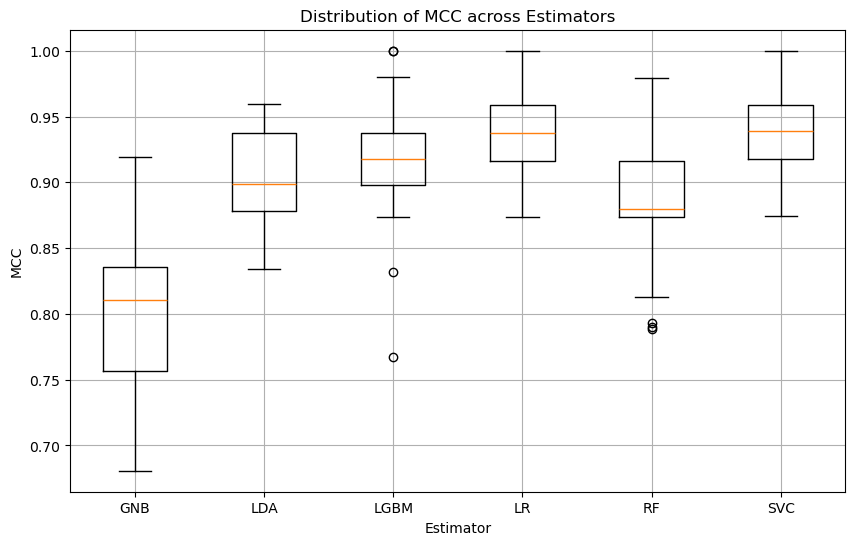

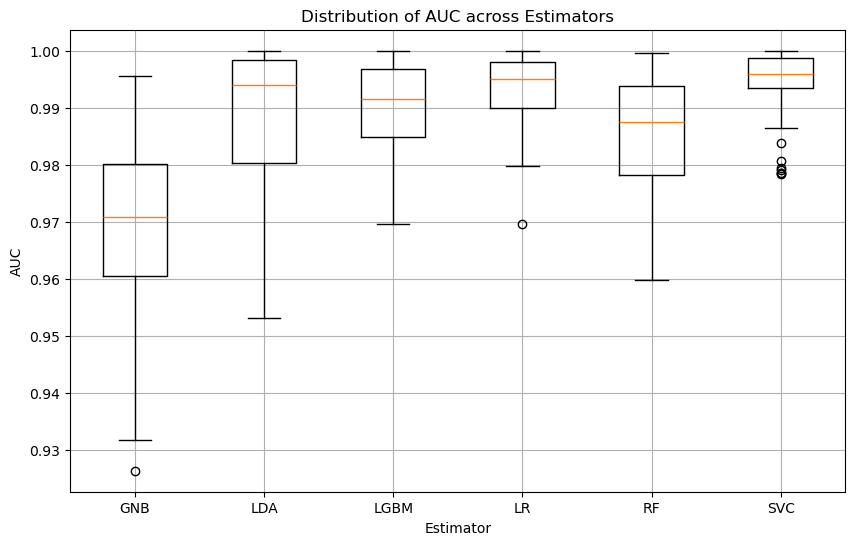

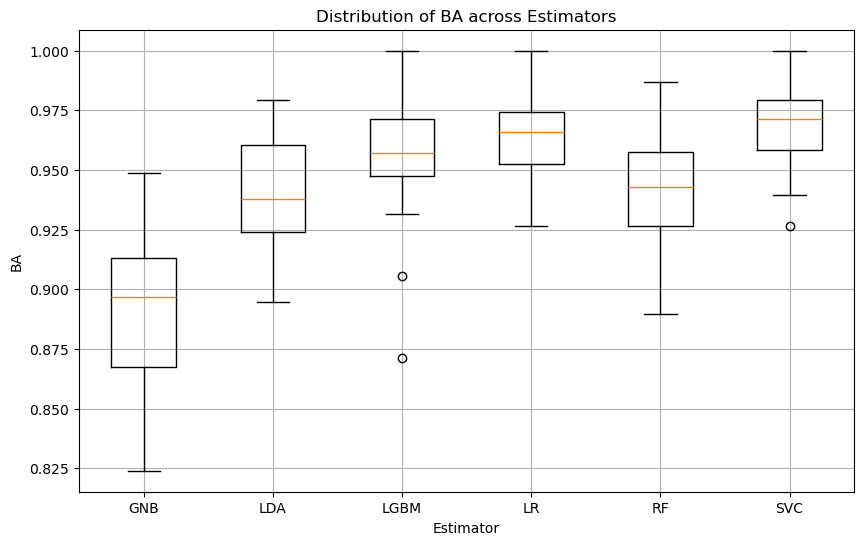

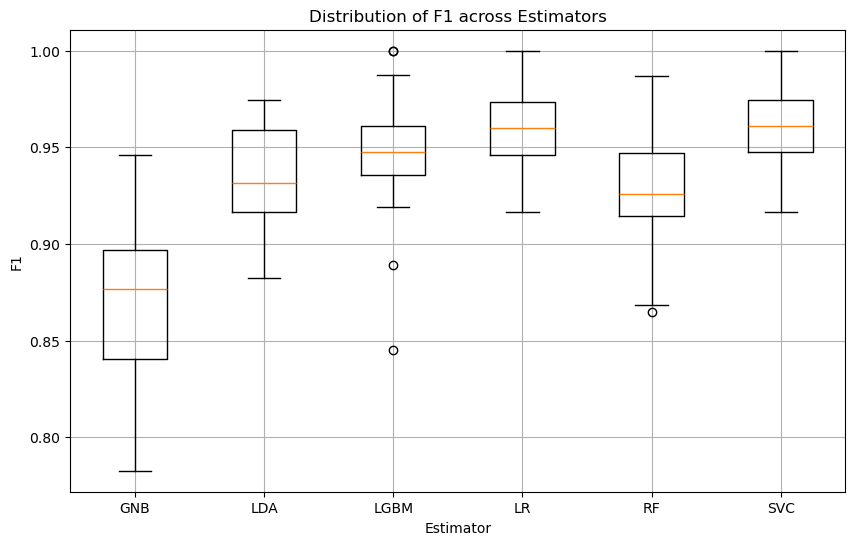

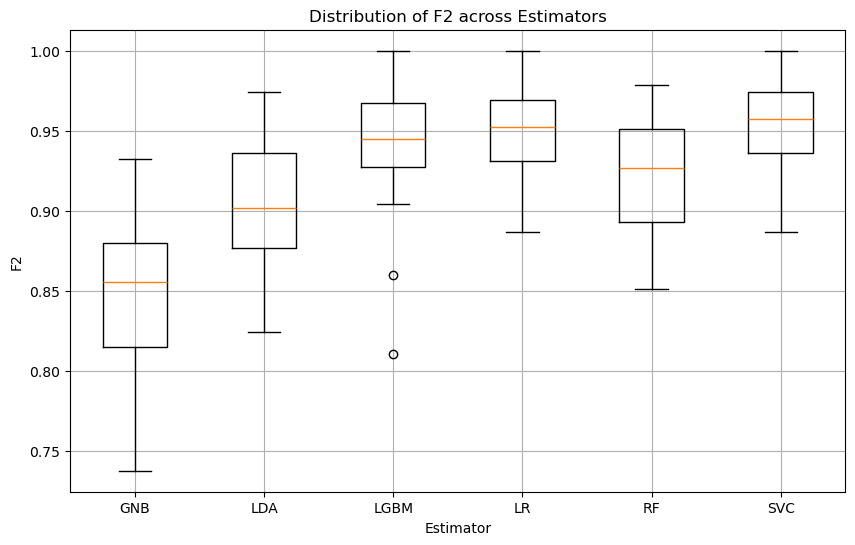

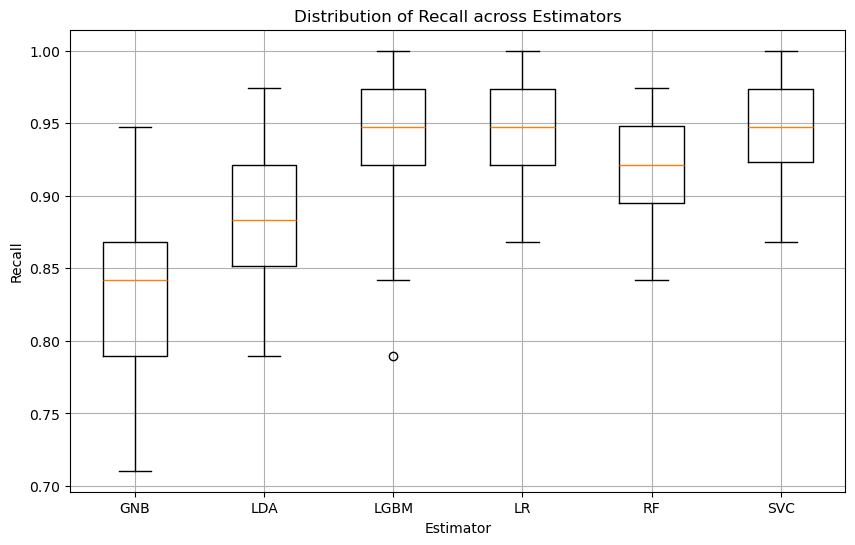

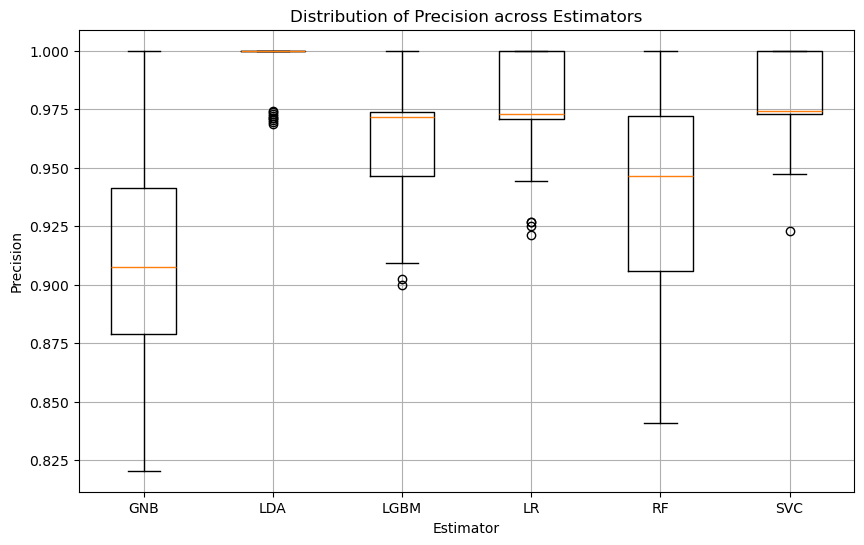

In [8]:
for metric_name in RepeatedNestedCV.METRICS:
    # Group scores by estimators
    grouped = df_results.groupby('estimator')[metric_name].apply(list)

    # Create boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(grouped.values, tick_labels=grouped.index)

    plt.title(f'Distribution of {metric_name} across Estimators')
    plt.xlabel('Estimator')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

### Median Performance Metrics

In [9]:
median_df = df_results.drop(columns=["repetition", "outer_fold"]).groupby("estimator").median()
median_df

,MCC,AUC,BA,F1,F2,Recall,Precision
estimator,,,,,,,
GNB,0.810617,0.970831,0.896682,0.876712,0.855615,0.842105,0.907670
LDA,0.898613,0.993911,0.937727,0.931507,0.901914,0.883266,1.000000
LGBM,0.917468,0.991587,0.957066,0.947368,0.944888,0.947368,0.971825
LR,0.937312,0.995066,0.965872,0.960000,0.952381,0.947368,0.972973
RF,0.879843,0.987480,0.943012,0.925915,0.926880,0.921053,0.946657
SVC,0.938810,0.995951,0.971337,0.961039,0.957447,0.947368,0.974359


### Bootstrap Confidence Intervals

In [10]:
from scipy.stats import bootstrap

def bootstrap_median_ci(data, confidence_level=0.95, n_resamples=10000, random_state=42):
    """
    Compute the confidence interval for the median using bootstrap resampling.

    Args:
        data (array-like): Input data values.
        confidence_level (float): Confidence level for the interval (default 95%).
        n_resamples (int): Number of bootstrap samples (default 10000).
        random_state (int): Random seed for reproducibility.

    Returns:
        (float, float): Lower and upper bounds of the confidence interval.
    """
    data = np.array(data)
    res = bootstrap((data,), np.median, confidence_level=confidence_level,
                    n_resamples=n_resamples, random_state=random_state, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

In [15]:
ci_summary = {}

for estimator in ['LR', 'SVC', 'LGBM']:
    ci_summary[estimator] = {}
    
    for metric in RepeatedNestedCV.METRICS:
        metric_scores = df_results[df_results['estimator'] == estimator][metric].dropna().values

        ci_low, ci_high = bootstrap_median_ci(metric_scores)

        # Store formatted CI string
        ci_summary[estimator][metric] = f"{ci_low:.4f}–{ci_high:.4f}"

# Create dataFrame
ci_summary_df = pd.DataFrame(ci_summary)

# Sort metrics alphabetically
ci_summary_df = ci_summary_df.sort_index()

# 95% Confidence Intervals for Median Metrics Across Estimators
ci_summary_df

,LR,SVC,LGBM
AUC,0.9932–0.9965,0.9935–0.9968,0.9880–0.9943
BA,0.9592–0.9734,0.9663–0.9811,0.9531–0.9614
F1,0.9580–0.9726,0.9484–0.9621,0.9454–0.9488
F2,0.9462–0.9591,0.9438–0.9669,0.9374–0.9589
MCC,0.9350–0.9570,0.9192–0.9403,0.9166–0.9189
Precision,0.9591–0.9737,0.9487–0.9754,0.9711–0.9949
Recall,0.9460–0.9474,0.9211–0.9474,0.9460–0.9737
